# Построение моделей предсказания надоя и качества молока коров

Нужно создать модели линейной и логичтической регрессии для покупки лучших коров на ферму.

## Цель
С помощью моделей нужно отобрать коров по двум критериям:
 - средний удой за год — не менее 6000 килограммов;
 - молоко должно быть вкусным.

## Описание данных:
### Текущее стадо
- `id` — уникальный идентификатор коровы.
- `Удой, кг` — масса молока, которую корова даёт в год (в килограммах).
- `ЭКЕ (Энергетическая кормовая единица)` — показатель питательности корма коровы.
- `Сырой протеин, г` — содержание сырого протеина в корме (в граммах).
- `СПО (Сахаро-протеиновое соотношение)` — отношение сахара к протеину в корме коровы.
- `Порода` — порода коровы.
- `Тип пастбища` — ландшафт лугов, на которых паслась корова.
- `порода папы_быка` — порода папы коровы.
- `Жирность,%` — содержание жиров в молоке (в процентах).
- `Белок,%` — содержание белков в молоке (в процентах).
- `Вкус молока` — оценка вкуса по личным критериям фермера, бинарный признак (вкусно, не вкусно).
- `Возраст` — возраст коровы, бинарный признак (менее_2_лет, более_2_лет).
### Родитель коров
- `id` — уникальный идентификатор коровы.
- `Имя Папы` — имя папы коровы.
### Продаваемые коровы
- `Порода` — порода коровы.
- `Тип пастбища` — ландшафт лугов, на которых паслась корова.
- `порода папы_быка` — порода папы коровы.
- `Имя_папы` — имя папы коровы.
- `Текущая_жирность,%` — содержание жиров в молоке (в процентах).
- `Текущий_уровень_белок,%` — содержание белков в молоке (в процентах).
- `Возраст` — возраст коровы, бинарный признак (менее_2_лет, более_2_лет).

## План исследования

1) Предобработка данных
2) Исследовательский анализ данных
3) Подготовка данных к ML
4) Обучение экспериментальных моделей линейной регрессии
5) Оценка метрик
6) Промежуточные выводы
7) Подготовка данных для логистической регрессии
8) Обучение экспериментальных моделей логистической регрессии
9) Оценка метрик
10) Промежуточные выводы
10) Общие выводы

##  Предобработка данных

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from datetime import datetime as dt
import math
from scipy import stats as st
import seaborn as sns
import phik
import matplotlib.patches as mpatches
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, accuracy_score, precision_score, recall_score, confusion_matrix

In [2]:
try:
    own_herd = pd.read_csv(r".\source\ferma_main.csv", sep=';')
    cows_ancestor = pd.read_csv(r".\source\ferma_dad.csv", sep=';')
    sale_herd = pd.read_csv(r".\source\cow_buy.csv", sep=';')
except:
    own_herd = pd.read_csv("/datasets/ferma_main.csv", sep=';')
    cows_ancestor = pd.read_csv("/datasets/ferma_dad.csv", sep=';')
    sale_herd = pd.read_csv("/datasets/cow_buy.csv", sep=';')

pd.set_option('display.max_columns', None)
print(f"Own heard:\n{own_herd.head(20)}")
print(f"Cows ancestors:\n{cows_ancestor.head(20)}")
print(f"Herd for sale:\n{sale_herd.head(20)}")

Own heard:
    id  Удой, кг ЭКЕ (Энергетическая кормовая единица)  Сырой протеин, г  \
0    1      5863                                  14,2              1743   
1    2      5529                                  12,8              2138   
2    3      5810                                    14              1854   
3    4      5895                                  12,4              2012   
4    5      5302                                  12,8              1675   
5    6      5254                                  12,7              1806   
6    7      5910                                  13,2              1792   
7    8      6179                                  14,7              1806   
8    9      6783                                  14,2              1918   
9   10      5339                                  13,4              1791   
10  11      5591                                  13,7              1678   
11  12      6563                                  16,5              2328   
1

Переименуем называния колонок на англоязычные, в соостветствии с конвенциональным именованием.

In [3]:
own_herd = own_herd.rename(columns={"Удой, кг": "yield",
                                    "ЭКЕ (Энергетическая кормовая единица)": "EFU",
                                    "Сырой протеин, г": "raw_protein",
                                    "СПО (Сахаро-протеиновое соотношение)": "SPR",
                                    "Порода": "breed",
                                    "Тип пастбища": "pasture_type",
                                    "порода папы_быка": "ancestor_breed",
                                    "Жирность,%": "fatness",
                                    "Белок,%": "proteins",
                                    "Вкус молока": "is_milk_tasty",
                                    "Возраст": "is_old",})
cows_ancestor = cows_ancestor.rename(columns={"Удой, кг": "yield",
                                    "Имя Папы": "ancestor_name"})
sale_herd = sale_herd.rename(columns={"Порода": "breed",
                                    "Тип пастбища": "pasture_type",
                                    "порода папы_быка": "ancestor_breed",
                                    "Имя_папы": "ancestor_name",
                                    "Текущая_жирность,%": "fatness",
                                    "Текущий_уровень_белок,%": "proteins",
                                    "Возраст": "is_old"})

In [4]:
own_herd.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 634 entries, 0 to 633
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   id              634 non-null    int64 
 1   yield           634 non-null    int64 
 2   EFU             634 non-null    object
 3   raw_protein     634 non-null    int64 
 4   SPR             634 non-null    object
 5   breed           634 non-null    object
 6   pasture_type    634 non-null    object
 7   ancestor_breed  634 non-null    object
 8   fatness         634 non-null    object
 9   proteins        634 non-null    object
 10  is_milk_tasty   634 non-null    object
 11  is_old          634 non-null    object
dtypes: int64(3), object(9)
memory usage: 59.6+ KB


In [5]:
cows_ancestor.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 629 entries, 0 to 628
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   id             629 non-null    int64 
 1   ancestor_name  629 non-null    object
dtypes: int64(1), object(1)
memory usage: 10.0+ KB


In [6]:
sale_herd.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20 entries, 0 to 19
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   breed           20 non-null     object
 1   pasture_type    20 non-null     object
 2   ancestor_breed  20 non-null     object
 3   ancestor_name   20 non-null     object
 4   fatness         20 non-null     object
 5   proteins        20 non-null     object
 6   is_old          20 non-null     object
dtypes: object(7)
memory usage: 1.2+ KB


Проверим наличие явных дубликатов.

In [7]:
def handle_duplicates(dataframe):
    duplicates_count = dataframe.duplicated().sum()

    if duplicates_count > 0:
        dataframe.drop_duplicates(inplace=True)
    
    print(f"Droped {duplicates_count} duplicates.")

In [8]:
handle_duplicates(own_herd)
handle_duplicates(cows_ancestor)
handle_duplicates(sale_herd)

Droped 5 duplicates.
Droped 0 duplicates.
Droped 4 duplicates.


Преобразуем данные к соответствующим типам.

In [9]:
def replace_fp_delimiter(columns, df):
    for col in columns:
        df[col] = df[col].str.replace(",", ".")

In [10]:
own_herd.nunique()

id                629
yield             528
EFU                55
raw_protein       401
SPR                12
breed               2
pasture_type        3
ancestor_breed      3
fatness            50
proteins           15
is_milk_tasty       2
is_old              2
dtype: int64

In [11]:
float_columns = ["EFU", "SPR", "fatness","proteins"]
replace_fp_delimiter(float_columns, own_herd)
own_herd = own_herd.astype({"EFU": "float",
                            "SPR": "float",
                            "breed": "category",
                            "pasture_type": "category",
                            "ancestor_breed": "category",
                            "fatness": "float",
                            "proteins": "float",
                            "is_milk_tasty": "category",
                            "is_old": "category"})

own_herd["is_milk_tasty"] = pd.Series([cow_milk == "вкусно" for cow_milk in own_herd["is_milk_tasty"]], dtype="category")
own_herd["is_old"] = pd.Series([cow_milk == "более_2_лет" for cow_milk in own_herd["is_old"]], dtype="category")

In [12]:
own_herd.head(1)

,id,yield,EFU,raw_protein,SPR,breed,pasture_type,ancestor_breed,fatness,proteins,is_milk_tasty,is_old
0,1,5863,14.2,1743,0.89,Вис Бик Айдиал,Равнинное,Айдиал,3.58,3.076,True,True


In [13]:
own_herd.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 629 entries, 0 to 628
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   id              629 non-null    int64   
 1   yield           629 non-null    int64   
 2   EFU             629 non-null    float64 
 3   raw_protein     629 non-null    int64   
 4   SPR             629 non-null    float64 
 5   breed           629 non-null    category
 6   pasture_type    629 non-null    category
 7   ancestor_breed  629 non-null    category
 8   fatness         629 non-null    float64 
 9   proteins        629 non-null    float64 
 10  is_milk_tasty   629 non-null    category
 11  is_old          629 non-null    category
dtypes: category(5), float64(4), int64(3)
memory usage: 43.0 KB


In [14]:
cows_ancestor.nunique()

id               629
ancestor_name      4
dtype: int64

In [15]:
cows_ancestor = cows_ancestor.astype({"ancestor_name": "category"})

In [16]:
cows_ancestor.head(1)

,id,ancestor_name
0,1,Буйный


In [17]:
cows_ancestor.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 629 entries, 0 to 628
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   id             629 non-null    int64   
 1   ancestor_name  629 non-null    category
dtypes: category(1), int64(1)
memory usage: 5.9 KB


In [18]:
sale_herd.nunique()

breed              2
pasture_type       2
ancestor_breed     2
ancestor_name      4
fatness           12
proteins          12
is_old             2
dtype: int64

In [19]:
float_columns = ["fatness","proteins"]
replace_fp_delimiter(float_columns, sale_herd)
sale_herd = sale_herd.astype({"breed": "category",
                            "pasture_type": "category",
                            "ancestor_breed": "category",
                            "ancestor_name": "category",
                            "fatness": "float",
                            "proteins": "float",
                            "is_old": "category"})

sale_herd["is_old"] = pd.Series([cow_milk == "более_2_лет" for cow_milk in sale_herd["is_old"]], dtype="category")

In [20]:
sale_herd.head(1)

,breed,pasture_type,ancestor_breed,ancestor_name,fatness,proteins,is_old
0,Вис Бик Айдиал,холмистое,Айдиал,Геркулес,3.58,3.076,True


In [21]:
sale_herd.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16 entries, 0 to 18
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   breed           16 non-null     category
 1   pasture_type    16 non-null     category
 2   ancestor_breed  16 non-null     category
 3   ancestor_name   16 non-null     category
 4   fatness         16 non-null     float64 
 5   proteins        16 non-null     float64 
 6   is_old          13 non-null     category
dtypes: category(5), float64(2)
memory usage: 1.1 KB


Проверим наличие пропусков в данных.

In [22]:
own_herd.isna().sum()

id                0
yield             0
EFU               0
raw_protein       0
SPR               0
breed             0
pasture_type      0
ancestor_breed    0
fatness           0
proteins          0
is_milk_tasty     0
is_old            0
dtype: int64

In [23]:
cows_ancestor.isna().sum()

id               0
ancestor_name    0
dtype: int64

In [24]:
sale_herd.isna().sum()

breed             0
pasture_type      0
ancestor_breed    0
ancestor_name     0
fatness           0
proteins          0
is_old            3
dtype: int64

Исправим описки в данных.

In [25]:
sale_herd["breed"] = sale_herd["breed"].replace("РефлешнСоверинг", "Рефлешн Соверинг")

## Исследовательский анализ данных

Рассмотрим описательную статистику данных.

In [26]:
own_herd.describe()

,id,yield,EFU,raw_protein,SPR,fatness,proteins
count,629.00000,629.000000,629.000000,629.000000,629.000000,629.000000,629.000000
mean,315.00000,6188.750397,14.543879,1923.364070,0.913116,3.603657,3.075671
std,181.72094,1644.795489,1.306408,182.956251,0.032203,0.168656,0.002549
min,1.00000,5204.000000,10.900000,1660.000000,0.840000,2.990000,3.069000
25%,158.00000,5751.000000,13.500000,1771.000000,0.890000,3.590000,3.074000
50%,315.00000,6133.000000,14.700000,1888.000000,0.930000,3.650000,3.076000
75%,472.00000,6501.000000,15.600000,2062.000000,0.940000,3.720000,3.077000
max,629.00000,45616.000000,16.800000,2349.000000,0.960000,3.750000,3.085000


Максимальный надой нереалистично большой. Вероятно, в данных есть выбросы.

In [27]:
sale_herd.describe()

,fatness,proteins
count,16.000000,16.000000
mean,3.571875,3.068250
std,0.141620,0.011264
min,3.340000,3.046000
25%,3.415000,3.059500
50%,3.585000,3.073500
75%,3.692500,3.076750
max,3.770000,3.081000


Для продаваемых коров количественные данные выглядят адекватно.

Далее рассмотрим в деталях каждый из признаков. Начнём с надоя.

<AxesSubplot:title={'center':'Надой коров'}, xlabel='Молока за год, кг', ylabel='Количество коров с таким надоем'>

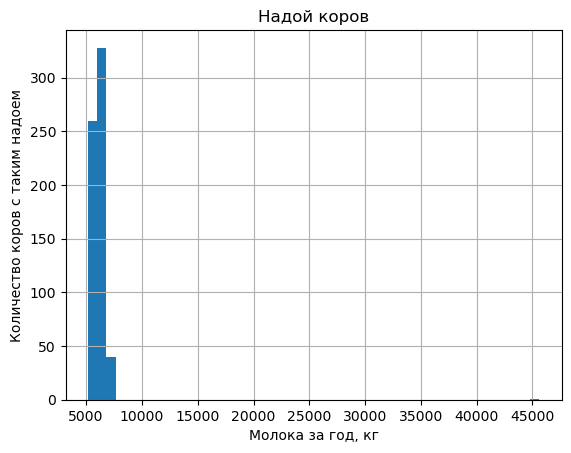

In [28]:
_, ax = plt.subplots()
ax.set_title('Надой коров')
ax.set_xlabel("Молока за год, кг")
ax.set_ylabel("Количество коров с таким надоем")
own_herd["yield"].hist(bins=50)

Удалим нереалистично большой выброс и построим график частот заново.

<AxesSubplot:title={'center':'Надой коров'}, xlabel='Молока за год, кг', ylabel='Количество коров с таким надоем'>

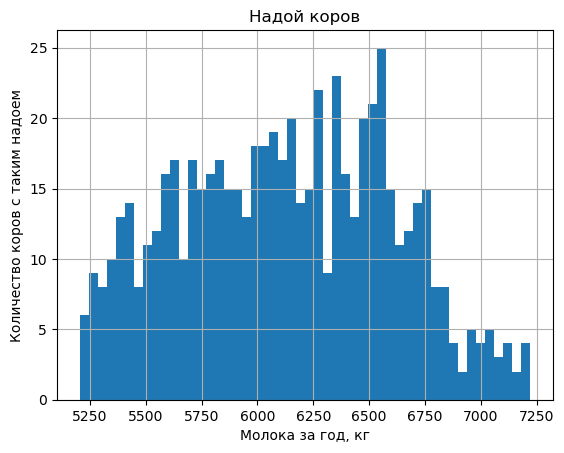

In [29]:
own_herd = own_herd[own_herd["yield"] < 15000]
_, ax = plt.subplots()
ax.set_title('Надой коров')
ax.set_xlabel("Молока за год, кг")
ax.set_ylabel("Количество коров с таким надоем")
own_herd["yield"].hist(bins=50)

Надой распределён унимодально. Коров, имеющих большие надои меньше. В целом, достаточно редко встречаются коровы с надоем больше 6900 кг в год.

<AxesSubplot:title={'center':'Питательность корма коров'}, xlabel='Питательность корма', ylabel='Количество коров с соответствующим кормом'>

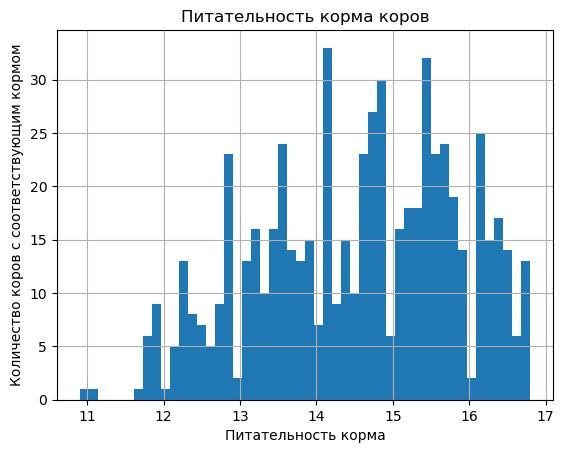

In [30]:
_, ax = plt.subplots()
ax.set_title('Питательность корма коров')
ax.set_xlabel("Питательность корма")
ax.set_ylabel("Количество коров с соответствующим кормом")
own_herd["EFU"].hist(bins=50)

На графике видно, что нескольким коровам попался корм с очень низкой энергетической ценностью. Стоит запомнить эту особенность и в дальнейшем решить, что с этим делать. Так же виден выброс, есть одна корова с крайне не питательнным кормом. Удалим её из выборки.

<AxesSubplot:title={'center':'Питательность корма коров'}, xlabel='Питательность корма', ylabel='Количество коров с соответствующим кормом'>

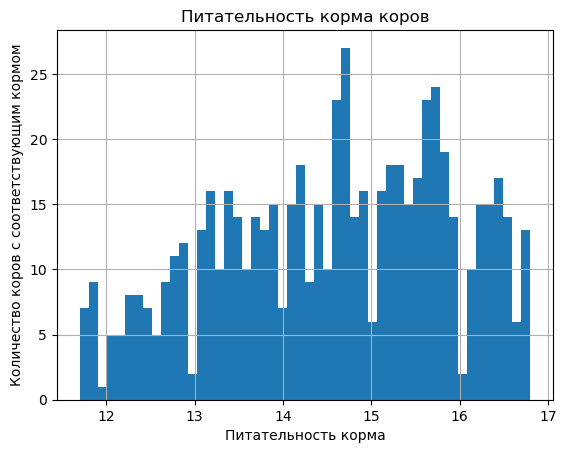

In [31]:
own_herd = own_herd[own_herd["EFU"] > 11.5]
_, ax = plt.subplots()
ax.set_title('Питательность корма коров')
ax.set_xlabel("Питательность корма")
ax.set_ylabel("Количество коров с соответствующим кормом")
own_herd["EFU"].hist(bins=50)

<AxesSubplot:title={'center':'Сахаро-протеиновое соотношение корма коров'}, xlabel='Отношение сахара к белкам', ylabel='Количество коров с соответствующим кормом'>

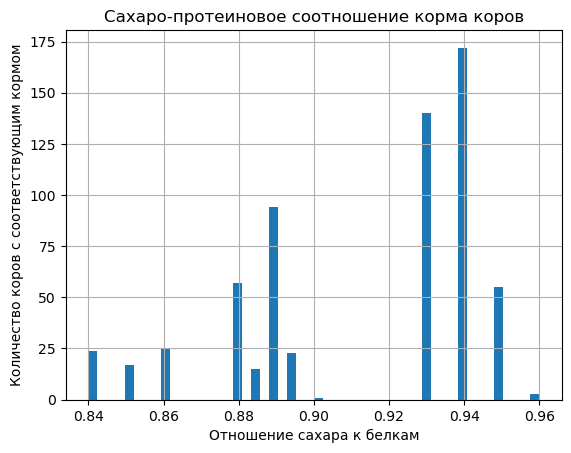

In [32]:
_, ax = plt.subplots()
ax.set_title('Сахаро-протеиновое соотношение корма коров')
ax.set_xlabel("Отношение сахара к белкам")
ax.set_ylabel("Количество коров с соответствующим кормом")
own_herd["SPR"].hist(bins=50)

Можно выделить три группы коров по сахаро-протеиновое соотношению в их корме: менее 0.87, от 0.87 до 0.91 и более 0.91. Рассмотрим как отличаются удой и вкус молока у коров из этих групп.

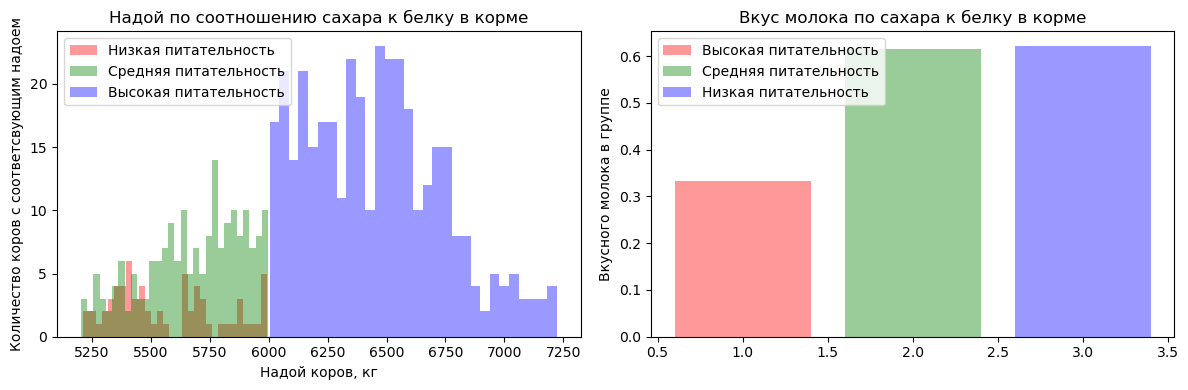

In [33]:
low_SPR = own_herd[own_herd["SPR"] < 0.87]
mid_SPR = own_herd[(own_herd["SPR"] >= 0.87) & (own_herd["SPR"] < 0.91)]
high_SPR = own_herd[own_herd["SPR"] >= 0.91]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
line11 = ax1.hist(low_SPR["yield"], bins=30, alpha = 0.4, color= 'r')
line12 = ax1.hist(mid_SPR["yield"], bins=30, alpha = 0.4, color= 'g')
line13 = ax1.hist(high_SPR["yield"], bins=30, alpha = 0.4, color= 'b')
ax1.set_title('Надой по соотношению сахара к белку в корме')
ax1.set_xlabel("Надой коров, кг")
ax1.set_ylabel("Количество коров с соответсвующим надоем")
ax1.legend(['Низкая питательность', 'Средняя питательность', 'Высокая питательность'])

line21 = ax2.bar(1, low_SPR[low_SPR["is_milk_tasty"]].shape[0] / low_SPR.shape[0], color= 'r', alpha = 0.4)
line22 = ax2.bar(2, mid_SPR[mid_SPR["is_milk_tasty"]].shape[0] / mid_SPR.shape[0], color= 'g', alpha = 0.4)
line23 = ax2.bar(3, high_SPR[high_SPR["is_milk_tasty"]].shape[0] / high_SPR.shape[0], color= 'b', alpha = 0.4)
ax2.set_title('Вкус молока по сахара к белку в корме')
ax2.set_ylabel("Вкусного молока в группе")
ax2.legend(['Высокая питательность', 'Средняя питательность', 'Низкая питательность'])

plt.tight_layout()
plt.show()

Делаем вывод что питательность корма может влиять на надой. Только корм с высокими энергетическими кормовыми единицами позволяет получить большие надои. Так же делаем вывод, что корм с низкой питательностью делает молоко невкусным.

<AxesSubplot:title={'center':'Содержание белка в корме коров'}, xlabel='Содержание белка, г', ylabel='Количество коров с соответствующим кормом'>

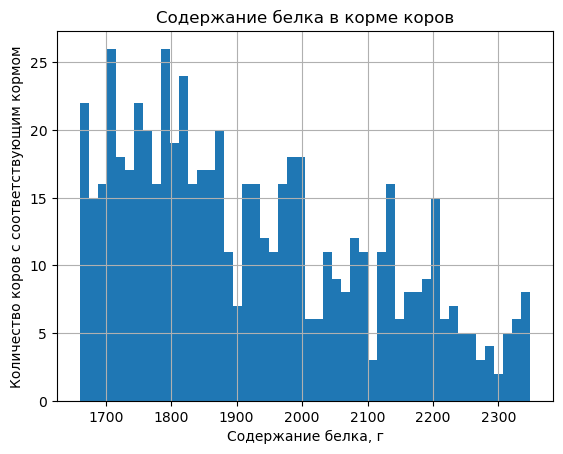

In [34]:
_, ax = plt.subplots()
ax.set_title('Содержание белка в корме коров')
ax.set_xlabel("Содержание белка, г")
ax.set_ylabel("Количество коров с соответствующим кормом")
own_herd["raw_protein"].hist(bins=50)

Видно что чаще всего коровам дают около 1750 белка в корме. Однако большая чась коров получает меньше белка в корме.

<AxesSubplot:title={'center':'Жирность молока коров'}, xlabel='Жирность молока, %', ylabel='Количество коров с соответствующей жирностью молока'>

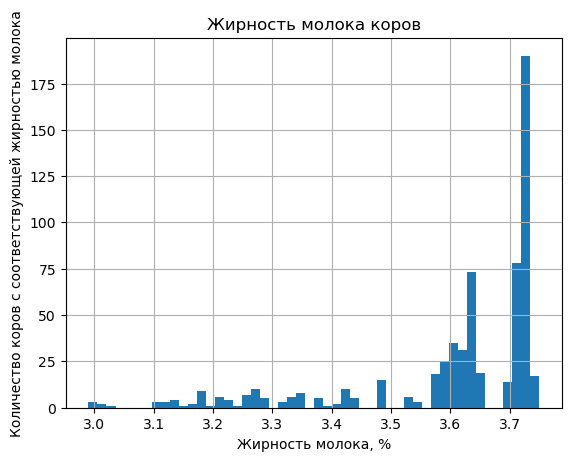

In [35]:
_, ax = plt.subplots()
ax.set_title('Жирность молока коров')
ax.set_xlabel("Жирность молока, %")
ax.set_ylabel("Количество коров с соответствующей жирностью молока")
own_herd["fatness"].hist(bins=50)

Видим, что значения жирности молока для большинства коров находятся в диапазоне 3.55% - 3.75%. Так же есть коровы, которые дают молоко с меньшей жирностью, но это редкость. Делаем вывод, что это не выбросы, т.к. таких коров достаточно много, а распределение этого признака, похоже, логнормальное.


<AxesSubplot:title={'center':'Количество белка в молоке коров'}, xlabel='Белок, %', ylabel='Количество коров с соответствующим содержанием белка в молоке'>

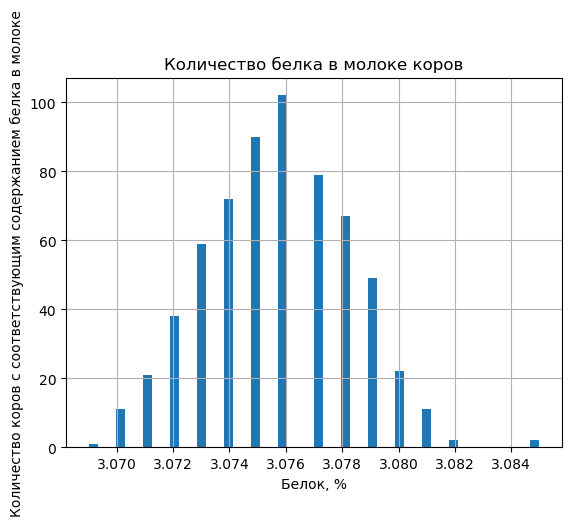

In [36]:
_, ax = plt.subplots()
ax.set_title('Количество белка в молоке коров')
ax.set_xlabel("Белок, %")
ax.set_ylabel("Количество коров с соответствующим содержанием белка в молоке")
own_herd["proteins"].hist(bins=50)

Содержание белка в молоке, похоже, распеределено нормально. Заметен выброс в сторону увеличения содержания белка. Т.к. выбросы составляют малую часть выборки по этому признаку, удалим их для лучшей стабилизации модели.

<AxesSubplot:title={'center':'Количество белка в молоке коров'}, xlabel='Белок, %', ylabel='Количество коров с соответствующим содержанием белка в молоке'>

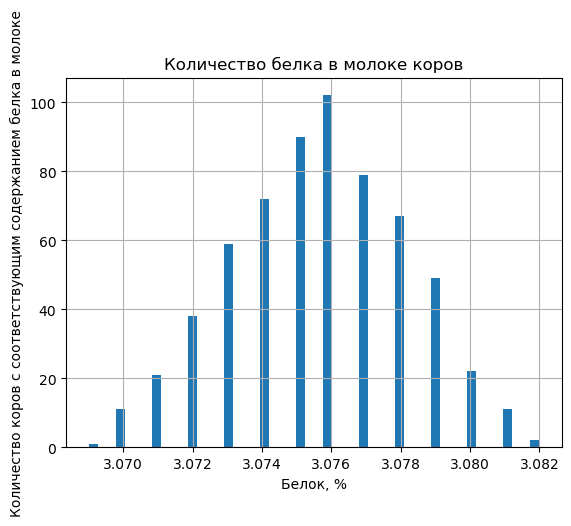

In [37]:

own_herd = own_herd[own_herd["proteins"] < 3.084]
_, ax = plt.subplots()
ax.set_title('Количество белка в молоке коров')
ax.set_xlabel("Белок, %")
ax.set_ylabel("Количество коров с соответствующим содержанием белка в молоке")
own_herd["proteins"].hist(bins=50)

Далее рассмотрим категориальные признаки.

In [38]:
own_herd.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 624 entries, 0 to 628
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   id              624 non-null    int64   
 1   yield           624 non-null    int64   
 2   EFU             624 non-null    float64 
 3   raw_protein     624 non-null    int64   
 4   SPR             624 non-null    float64 
 5   breed           624 non-null    category
 6   pasture_type    624 non-null    category
 7   ancestor_breed  624 non-null    category
 8   fatness         624 non-null    float64 
 9   proteins        624 non-null    float64 
 10  is_milk_tasty   624 non-null    category
 11  is_old          624 non-null    category
dtypes: category(5), float64(4), int64(3)
memory usage: 42.7 KB


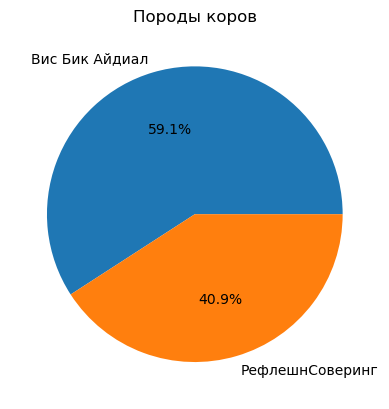

In [39]:
distribution = own_herd["breed"].value_counts()
fig, ax = plt.subplots()
ax.pie(distribution, labels = distribution.index, autopct="%1.1f%%")
ax.set_title("Породы коров")
plt.show()

В стеде фермера немного больше коров породы Вис Бик Айдиал.

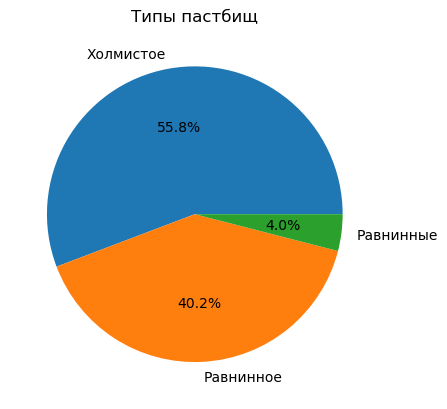

In [40]:
distribution = own_herd["pasture_type"].value_counts()
fig, ax = plt.subplots()
ax.pie(distribution, labels = distribution.index, autopct="%1.1f%%")
ax.set_title("Типы пастбищ")
plt.show()

Исправим описку и объеденим две одинаковые по сути категории.

In [41]:
own_herd["pasture_type"].dtype

CategoricalDtype(categories=['Равнинное', 'Равнинные', 'Холмистое'], ordered=False)

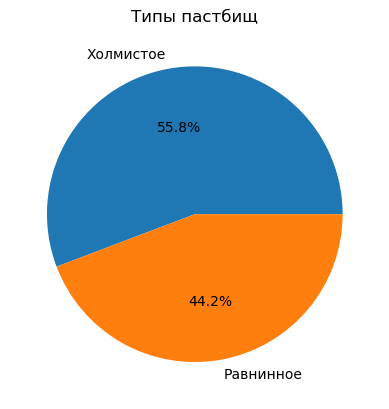

In [42]:
own_herd["pasture_type"] = own_herd["pasture_type"].apply(lambda x: "Равнинное" if x == "Равнинные" else x)
distribution = own_herd["pasture_type"].value_counts()
fig, ax = plt.subplots()
ax.pie(distribution, labels = distribution.index, autopct="%1.1f%%")
ax.set_title("Типы пастбищ")
plt.show()

Незначительно больше коров паслись на холмистых пастбищах.

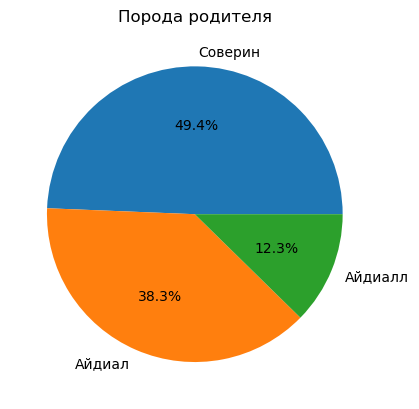

In [43]:
distribution = own_herd["ancestor_breed"].value_counts()
fig, ax = plt.subplots()
ax.pie(distribution, labels = distribution.index, autopct="%1.1f%%")
ax.set_title("Порода родителя")
plt.show()

Исправим описку и объеденим две одинаковые по сути категории.

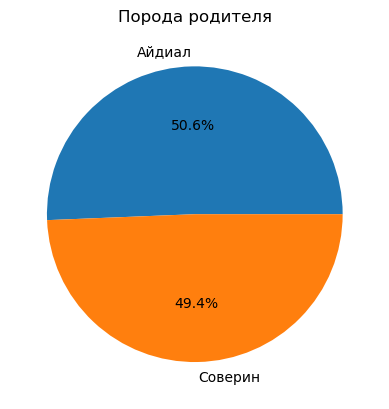

In [44]:
own_herd["ancestor_breed"] = own_herd["ancestor_breed"].apply(lambda x: "Айдиал" if x == "Айдиалл" else x)
distribution = own_herd["ancestor_breed"].value_counts()
fig, ax = plt.subplots()
ax.pie(distribution, labels = distribution.index, autopct="%1.1f%%")
ax.set_title("Порода родителя")
plt.show()

Почти одинаковое количество коров в стаде имеют происхождение Соверин и Айдиал.

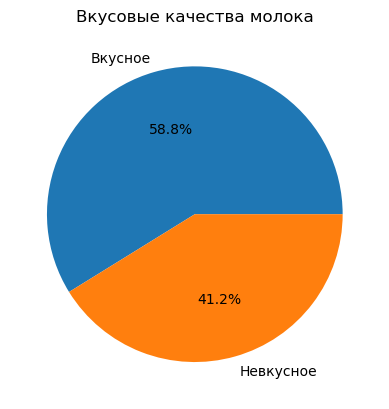

In [45]:
distribution = own_herd["is_milk_tasty"].value_counts()
fig, ax = plt.subplots()
ax.pie(distribution, labels = ['Вкусное', 'Невкусное'], autopct="%1.1f%%")
ax.set_title("Вкусовые качества молока")
plt.show()

Чуть больше половины коров в стаде фермера дают вкусное по его мнению молоко. Вызывает вопросы к фермеру, зачем он держит таких коров, если считает их молоко невкусным...

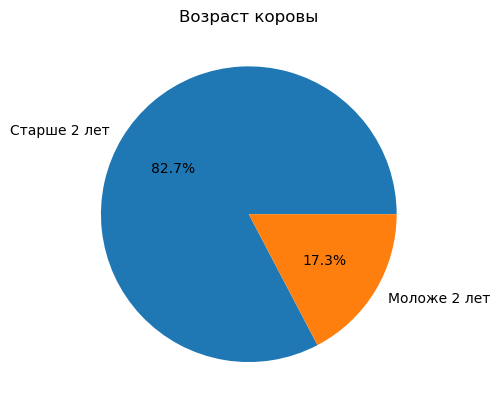

In [46]:
distribution = own_herd["is_old"].value_counts()
fig, ax = plt.subplots()
ax.pie(distribution, labels = ["Старше 2 лет", "Моложе 2 лет"], autopct="%1.1f%%")
ax.set_title("Возраст коровы")
plt.show()

Посмотрим на таблицу родителей коров в ферме.

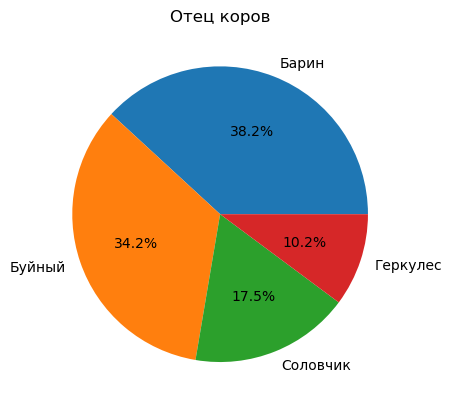

In [47]:
distribution = cows_ancestor["ancestor_name"].value_counts()
fig, ax = plt.subplots()
ax.pie(distribution, labels = distribution.index, autopct="%1.1f%%")
ax.set_title("Отец коров")
plt.show()

Ничего особенного. Далее проанализируем данные продаваемых коров.

<AxesSubplot:title={'center':'Жирность молока продаваемых коров'}, xlabel='Жирность молока, %', ylabel='Количество коров с соответствующей жирностью молока'>

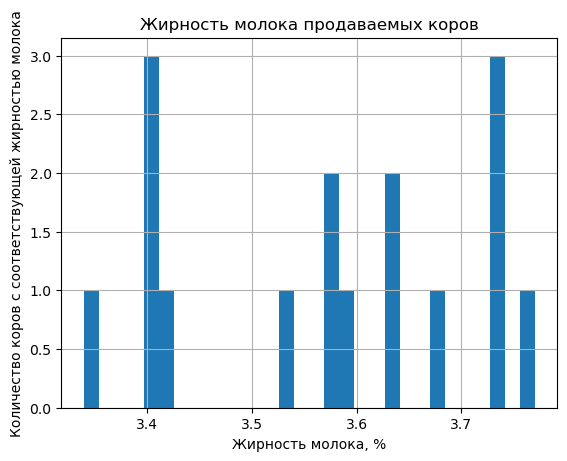

In [48]:
_, ax = plt.subplots()
ax.set_title('Жирность молока продаваемых коров')
ax.set_xlabel("Жирность молока, %")
ax.set_ylabel("Количество коров с соответствующей жирностью молока")
sale_herd["fatness"].hist(bins=30)

Заметно, что у большего количества продаваемых коров жирность молока ниже средних и наиболее часто встречаемых значений стада фермера. 

<AxesSubplot:title={'center':'Количество белка в молоке продаваемых коров'}, xlabel='Белок, %', ylabel='Количество коров с соответствующим содержанием белка в молоке'>

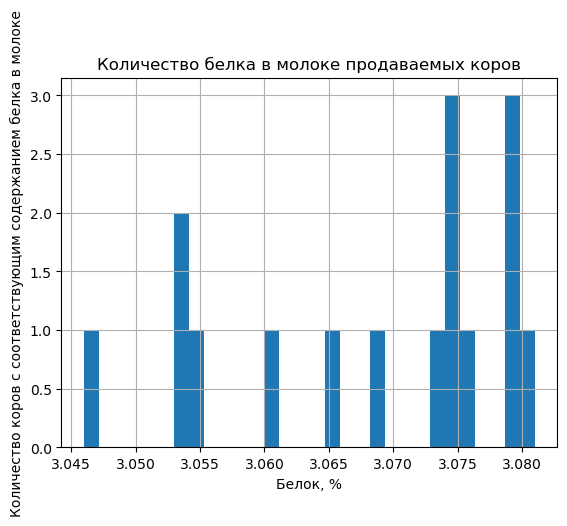

In [49]:
_, ax = plt.subplots()
ax.set_title('Количество белка в молоке продаваемых коров')
ax.set_xlabel("Белок, %")
ax.set_ylabel("Количество коров с соответствующим содержанием белка в молоке")
sale_herd["proteins"].hist(bins=30)

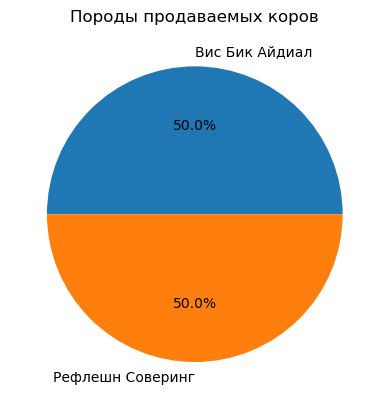

In [50]:
distribution = sale_herd["breed"].value_counts()
fig, ax = plt.subplots()
ax.pie(distribution, labels = distribution.index, autopct="%1.1f%%")
ax.set_title("Породы продаваемых коров")
plt.show()

Продаётся одинаковое количество коров с двумя разными породами.

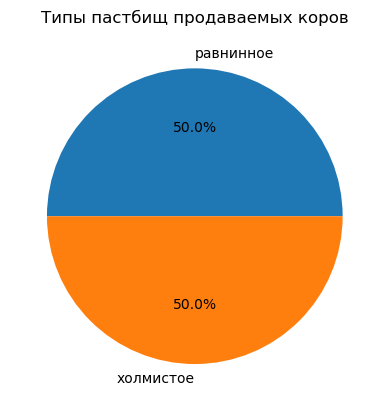

In [51]:
distribution = sale_herd["pasture_type"].value_counts()
fig, ax = plt.subplots()
ax.pie(distribution, labels = distribution.index, autopct="%1.1f%%")
ax.set_title("Типы пастбищ продаваемых коров")
plt.show()

Продаётся одинаковое количество коров пасущихся на двух разных типах пастбищ.

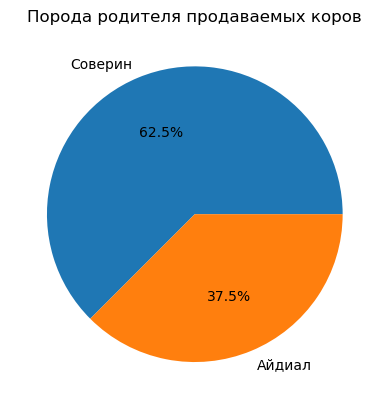

In [52]:
distribution = sale_herd["ancestor_breed"].value_counts()
fig, ax = plt.subplots()
ax.pie(distribution, labels = distribution.index, autopct="%1.1f%%")
ax.set_title("Порода родителя продаваемых коров")
plt.show()

Большинство продаваемых коров породы Соверин.

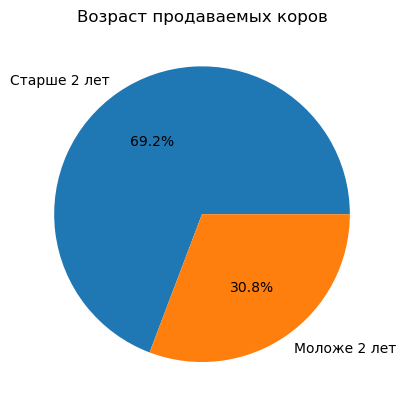

In [53]:
distribution = sale_herd["is_old"].value_counts()
fig, ax = plt.subplots()
ax.pie(distribution, labels = ["Старше 2 лет", "Моложе 2 лет"], autopct="%1.1f%%")
ax.set_title("Возраст продаваемых коров")
plt.show()

В стаде продаваемых коров чуть больше молодых, с возрастом менее двух лет.

Распределение насыщенности белком молока продаваемых коров отличается от коров из стада фермера. Выборка меньше и содержит около половины коров с содержанием белка в молоке ниже, чем в стаде фермера.

В численных признаках коров фермера были устранены выбросы, в категориальных унифицированы классы.

При анализе сахоро-протеинового соотношения коров фермера было выявлено три группы коров по этому признаку. Дальнейший анализ показал что низкая и средняя питательность корма негативно влияет на целевые признаки надоя и вкуса молока.

Жирность молока коров фермера, похоже, распределена логнормально.

Количество белка в молоке коров фермера, похоже, распределено нормально.

Странным является факт, что частоты распределения родителя коров фермера и их породы различаются на 8.5%. В дальнейшем стоит постараться найти ответ, почему.

Большинство коров фермера в стаде взрослые, т.е. старше двух лет.

Для количественных данных имеет нужно провести стандартизацию признаков в ходе подготовки данных к обучению модели.

## Корреляционный анализ

Для начала построим кореляционную матрицу в виде тепловой карты.

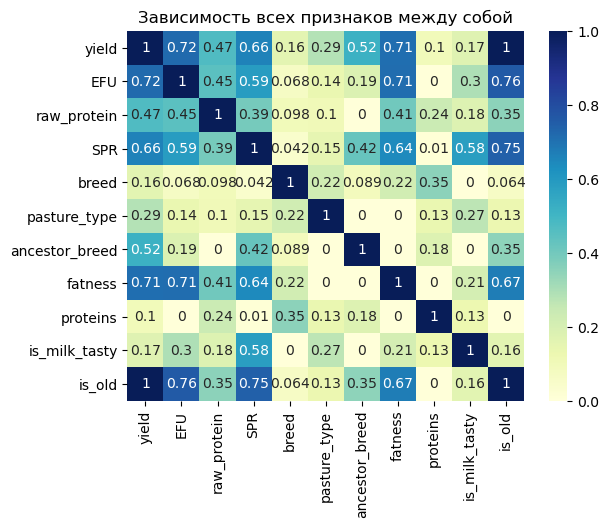

In [54]:
ax = plt.axes()
phi_k = own_herd.drop("id", axis = 1).phik_matrix(interval_cols = ["yield", "EFU", "raw_protein", "SPR", "fatness", "proteins"])
sns.heatmap(phi_k, cmap = "YlGnBu", annot = True)
ax.set_title('Зависимость всех признаков между собой')
plt.show()

Целевые признаки:
1) Надой:
    - сильно влияют на надой:
        - возраст (старше 2 лет) коровы дают молоко
        - питательности корма (EFU)
        - жирность молока
        - сахаро-протеиновое соотношение корма
    - средне влияет на надой:
        - порода отца коровы
        - количество белков в корме коровы
    - незначительно влияют на надой:
        - тип пастбища
        - вкусовые качества молока
        - порода коровы
    - почти не влияет на надой содержание белка в молоке коровы
2) Вкус молока:
    - вкус молока сильно зависит от:
        - сахаро-протеинового соотношения корма
    - в средней степени зависит от:
        - питательности корма (EFU)
        - тип пастбища
        - жирность молока
    - почти не влияют:
        - содержание белка в корме
        - надой
        - возраст (старше 2 лет) коровы
        - насыщенность молока белком
    - совершенно не влияют:
        - порода отца коровы
        - порода коровы

Зависимость признаков между собой:
- возраст коровы и питательность её корма
- жирность молока и питательность корма
- питательность корма и сахаро-протеинового соотношение корма
- возраст коровы и сахаро-протеинового соотношение корма
- сахаро-протеинового соотношение корма и возраст коровы
- жирность молока от возраста коровы


Делаем вывод, что для предсказания вкуса молока можно не использовать признаки, касающиеся породы коровы. Так же полезно рассмотреть типы зависимости для признаков с высокой и средней зависимостью с целевыми и так же построить зависимости выделенных выше прогнозных признаков между собой.

Построим наглядно зависимости целевых признаков от прогнозных.

In [55]:
features = [
        ("EFU", "Питательность корма"), 
        ("proteins", "Содержание белка в молоке"), 
        ("SPR", "Сахаро-протеиновое соотношение"), 
        ("raw_protein", "Содержание белка в корме"), 
        ("fatness", "Жирность молока")
    ]

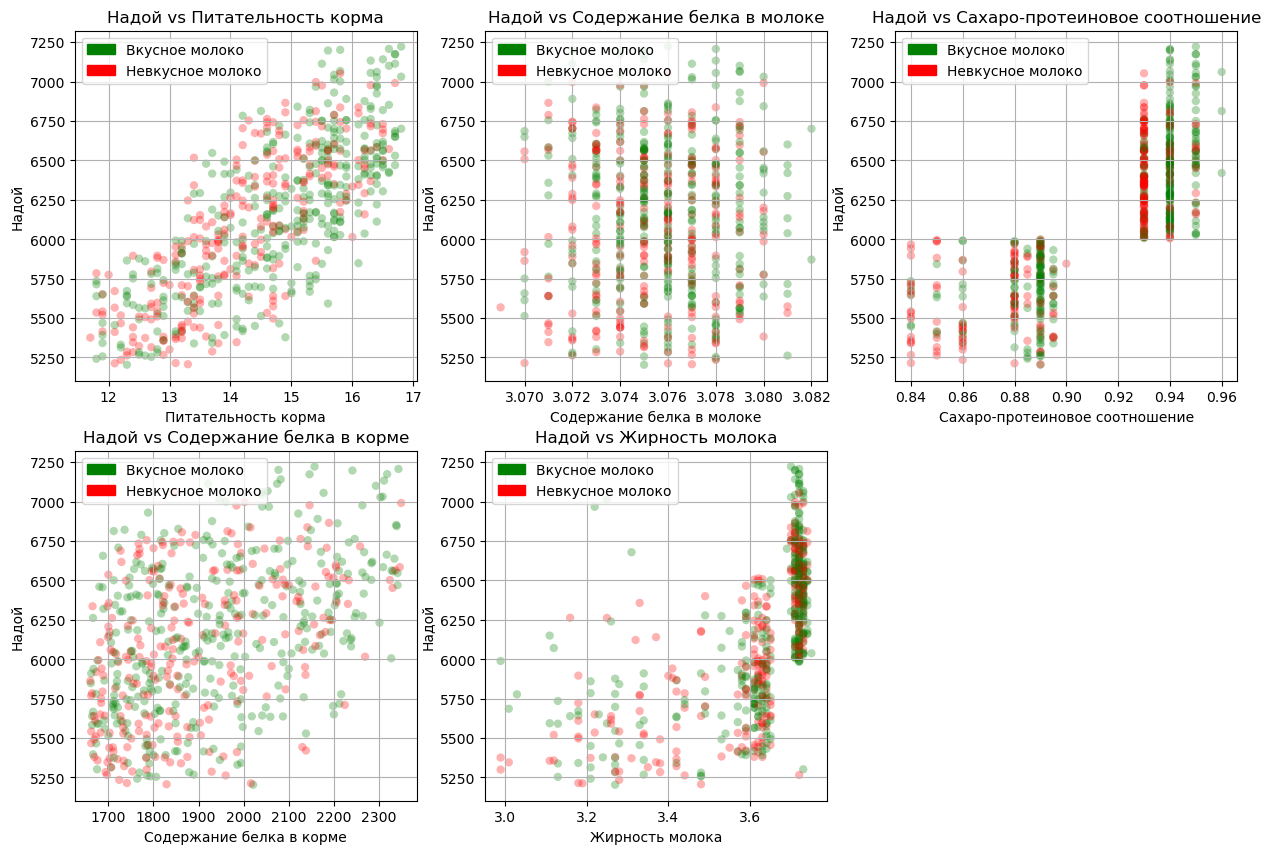

In [56]:
fig, ax = plt.subplots(2, 3, figsize=(15, 10))
for idx, (feature, feature_name) in enumerate(features):
    color = ["green" if is_milk_tasty else "red" for is_milk_tasty in own_herd["is_milk_tasty"]]
    x = idx % 3
    y = idx // 3
    sct = ax[y, x].scatter(own_herd[feature].to_list(), own_herd["yield"].to_list(), c=color,
               alpha=0.3, edgecolors="none")
    ax[y, x].set_title(f"Надой vs {feature_name}")
    ax[y, x].set(xlabel=feature_name, ylabel="Надой")
    legend_handles = [
        mpatches.Patch(color="green", label="Вкусное молоко"),
        mpatches.Patch(color="red",   label="Невкусное молоко"),
    ]
    ax[y, x].legend(handles=legend_handles)
    ax[y, x].grid(True)
ax[-1, -1].axis('off')

plt.show()

Заметно, что надой линейно зависит от питательности корма. Так же чем выше питательность и сахаро-протеиновое соотношение корма, тем выше вкусовые качества молока. Содержание белка в молоке никак не влияет ни на жирность, ни на надой. Лучшим сахарно-протеиновым соотношением для вкуса молока являются значения выше 0.89 с исключением близким к 0.93. При этом характер зависимости сахаро-протеинового соотношения к надою нелинеен и явно показывает, что для болшьших надоев коровам стоит давать корм с соотношением выше 0.93. Содержание белка в корме почти никак не влияет на вкус и надой, что подтверждается графиком. Жирность молока положительно влияет на надой и вкус молока, но зависимость нелинейная.

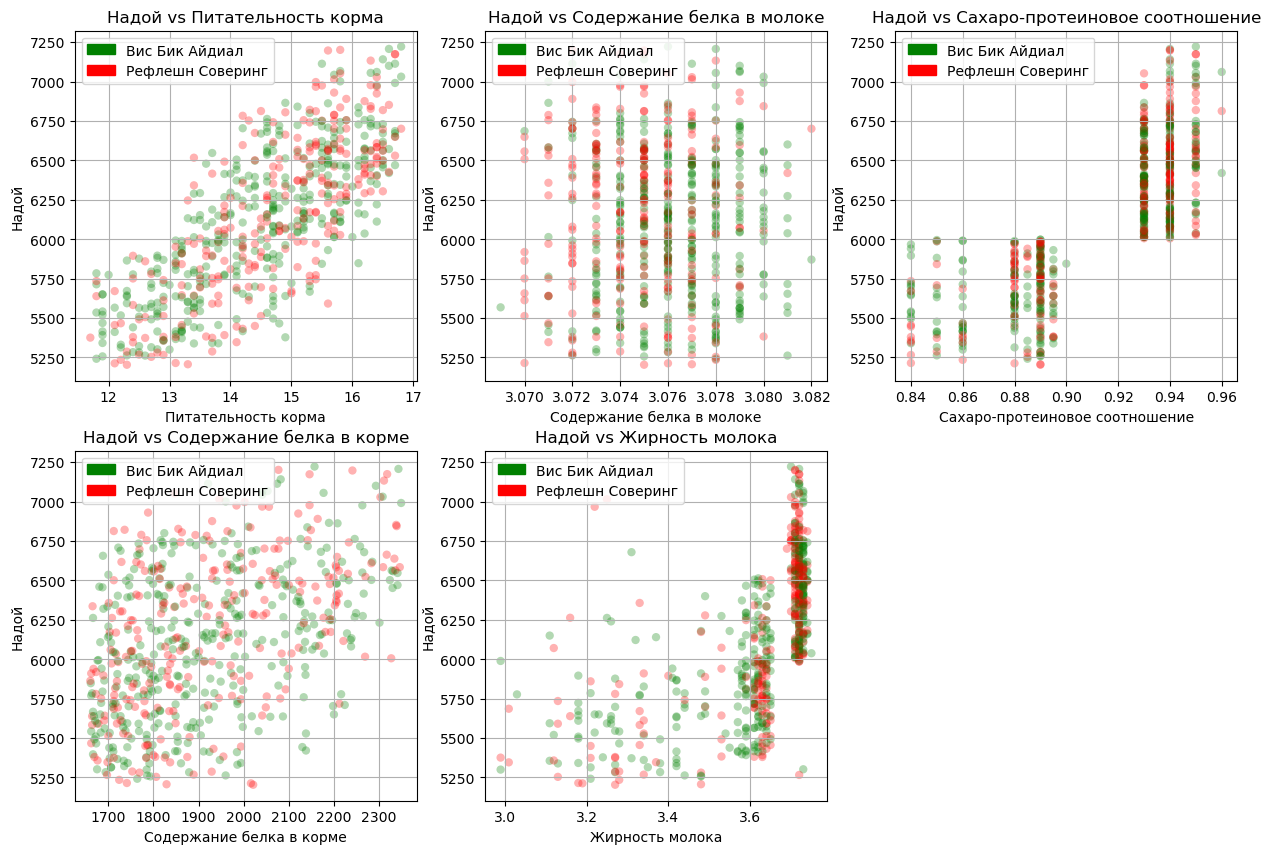

In [57]:
fig, ax = plt.subplots(2, 3, figsize=(15, 10))
for idx, (feature, feature_name) in enumerate(features):
    color = ["green" if breed == "Вис Бик Айдиал" else "red" for breed in own_herd["breed"]]
    x = idx % 3
    y = idx // 3
    sct = ax[y, x].scatter(own_herd[feature].to_list(), own_herd["yield"].to_list(), c=color,
               alpha=0.3, edgecolors="none")
    ax[y, x].set_title(f"Надой vs {feature_name}")
    ax[y, x].set(xlabel=feature_name, ylabel="Надой")
    legend_handles = [
        mpatches.Patch(color="green", label="Вис Бик Айдиал"),
        mpatches.Patch(color="red",   label="Рефлешн Соверинг"),
    ]
    ax[y, x].legend(handles=legend_handles)
    ax[y, x].grid(True)
ax[-1, -1].axis('off')

plt.show()

Заметно, что содержание белка в молоке породы Вис Бик Айдиал больше. Так же молоко этой породы имеет чуть большую жирность.

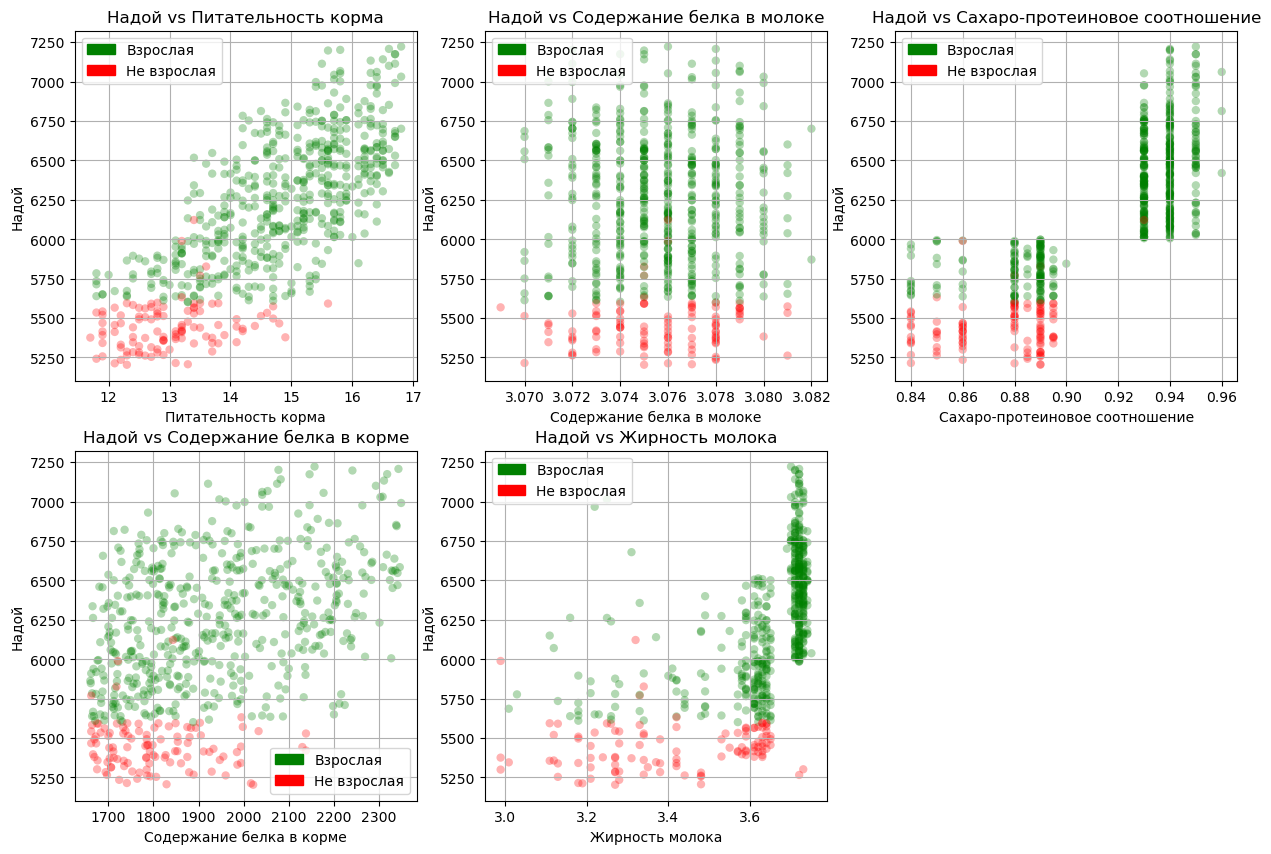

In [58]:
fig, ax = plt.subplots(2, 3, figsize=(15, 10))
for idx, (feature, feature_name) in enumerate(features):
    color = ["green" if is_old else "red" for is_old in own_herd["is_old"]]
    x = idx % 3
    y = idx // 3
    sct = ax[y, x].scatter(own_herd[feature].to_list(), own_herd["yield"].to_list(), c=color,
               alpha=0.3, edgecolors="none")
    ax[y, x].set_title(f"Надой vs {feature_name}")
    ax[y, x].set(xlabel=feature_name, ylabel="Надой")
    legend_handles = [
        mpatches.Patch(color="green", label="Взрослая"),
        mpatches.Patch(color="red",   label="Не взрослая"),
    ]
    ax[y, x].legend(handles=legend_handles)
    ax[y, x].grid(True)
ax[-1, -1].axis('off')

plt.show()

Возраст коров менее двух лет очевидным образом влияет на мелкие надои.

In [59]:
own_herd["pasture_type"].value_counts()

Холмистое    348
Равнинное    276
Name: pasture_type, dtype: int64

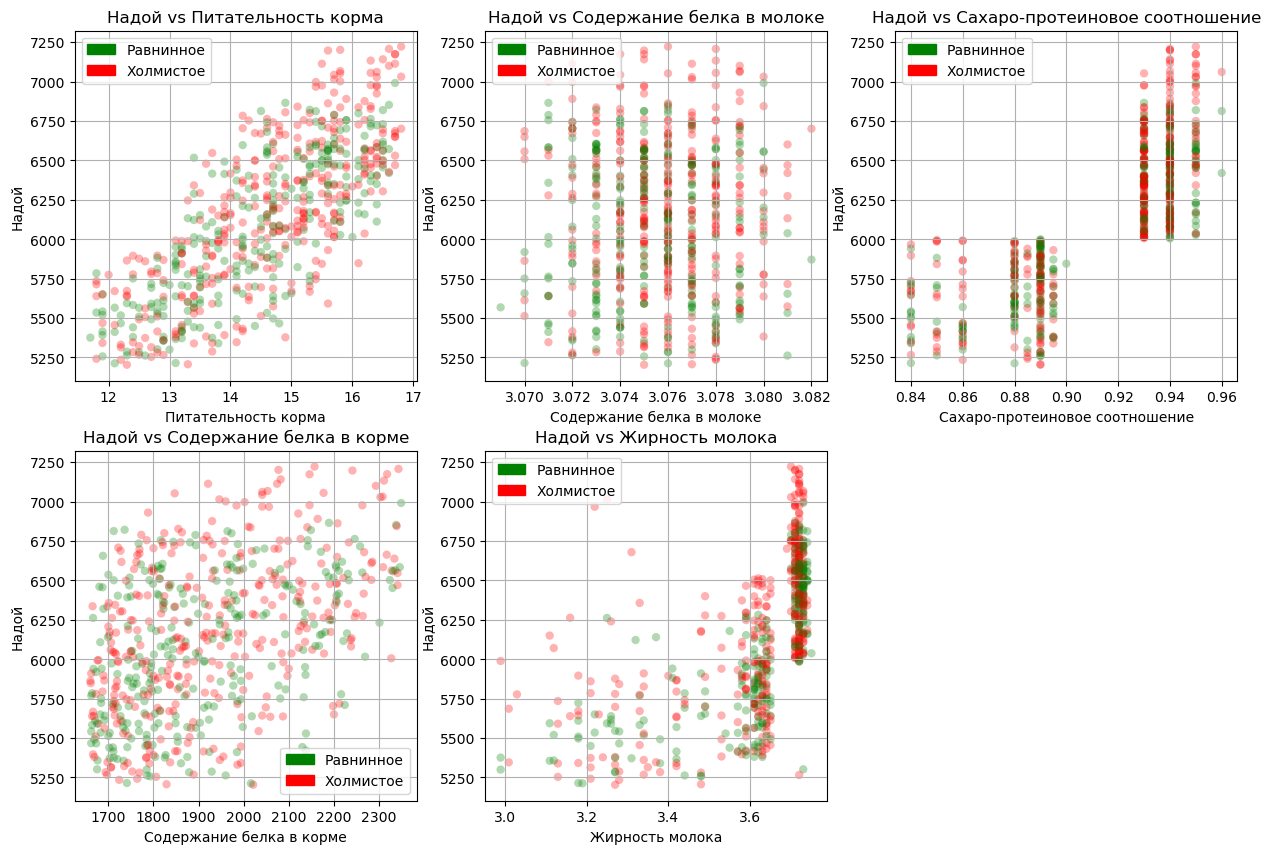

In [60]:
fig, ax = plt.subplots(2, 3, figsize=(15, 10))
for idx, (feature, feature_name) in enumerate(features):
    color = ["green" if pasture_type == "Равнинное" else "red" for pasture_type in own_herd["pasture_type"]]
    x = idx % 3
    y = idx // 3
    sct = ax[y, x].scatter(own_herd[feature].to_list(), own_herd["yield"].to_list(), c=color,
               alpha=0.3, edgecolors="none")
    ax[y, x].set_title(f"Надой vs {feature_name}")
    ax[y, x].set(xlabel=feature_name, ylabel="Надой")
    legend_handles = [
        mpatches.Patch(color="green", label="Равнинное"),
        mpatches.Patch(color="red",   label="Холмистое"),
    ]
    ax[y, x].legend(handles=legend_handles)
    ax[y, x].grid(True)
ax[-1, -1].axis('off')

plt.show()

Холмистый тип пастбища незначительно влияет на большую  жирность молока и большие надои.

### Выводы о связях удоя и остальных признаков

Для анализа мультиколлениарности визуализируем связь скоррелированного с питатьельностью признака.

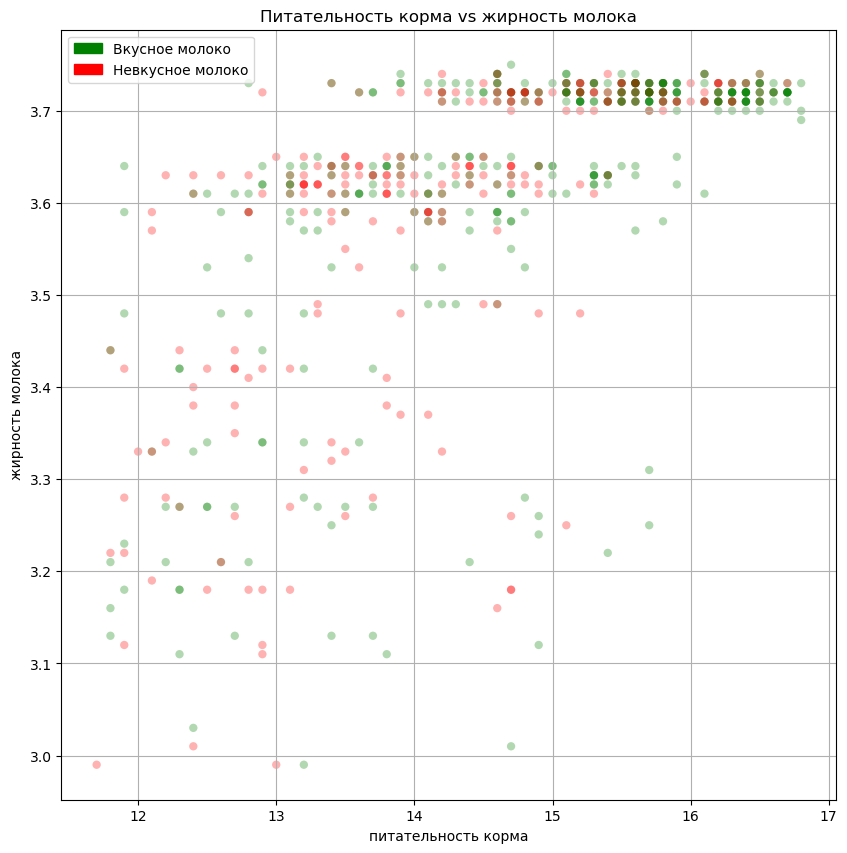

In [61]:
fig, ax = plt.subplots(figsize=(10, 10))
color = ["green" if is_milk_tasty else "red" for is_milk_tasty in own_herd["is_milk_tasty"]]
sct = ax.scatter(own_herd["EFU"].to_list(), own_herd["fatness"].to_list(), c=color,
            alpha=0.3, edgecolors="none")
ax.set_title(f"Питательность корма vs жирность молока")
ax.set(xlabel="питательность корма", ylabel="жирность молока")
legend_handles = [
    mpatches.Patch(color="green", label="Вкусное молоко"),
    mpatches.Patch(color="red",   label="Невкусное молоко"),
]
ax.legend(handles=legend_handles)
ax.grid(True)
plt.show()

- Связь надоя линейно зависима от питательности корма, нелинейно зависима от сахаро-протеинового соотношения и жирности молока, а для других количественных признаков несущественна. Так же на холмистых пастбищах надои незначительно выше.
- Для жирности молока и сахаро-протеинового соотношения корма можно ввести новые категориальные признаки с 3 значениями.
- Однозначно ответить на вопрос о мультиколлинеарности питательности корма и жирности молока не получается т.к. корреляция достаточно высокая, но диаграмма рассеяния не показывает явной связи между признаками. Вероятно, стоит дальше рассмотреть новый признак как отношение жирности молока к питательности корма т.к. питание является, вероятно, влияющим на жирность фактором. 

## Обучение модели линейной регрессии

In [62]:
own_herd.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 624 entries, 0 to 628
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   id              624 non-null    int64   
 1   yield           624 non-null    int64   
 2   EFU             624 non-null    float64 
 3   raw_protein     624 non-null    int64   
 4   SPR             624 non-null    float64 
 5   breed           624 non-null    category
 6   pasture_type    624 non-null    object  
 7   ancestor_breed  624 non-null    object  
 8   fatness         624 non-null    float64 
 9   proteins        624 non-null    float64 
 10  is_milk_tasty   624 non-null    category
 11  is_old          624 non-null    category
dtypes: category(3), float64(4), int64(3), object(2)
memory usage: 50.9+ KB


Т.к. ранее было отмечено, что только взрослые коровы могут давать большие надои и учитывая, что физиология взрослых и молодых коров различается, стоит исключить всех коров моложе двух лет из анализа.

In [63]:
own_herd = own_herd[own_herd["is_old"] == True]

Оставим только числовые признаки для обучения модели линейной регрессии.

In [64]:
X = own_herd.drop([ "yield", "id", "is_milk_tasty", "is_old"], axis = 1)
y = own_herd["yield"]
X_train, X_test, y_train, y_test_1 = train_test_split(X, y, test_size=0.2)
X_train = pd.get_dummies(X_train, drop_first=True)
X_test = pd.get_dummies(X_test, drop_first=True)
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

model_1 = LinearRegression()
model_1.fit(X_train, y_train)

y_pred_1 = model_1.predict(X_test)


Проанализируем качество получившейся модели.

In [65]:
r2 = r2_score(y_test_1, y_pred_1)
print(f"Значение R2 первой модели: {r2}")

Значение R2 первой модели: 0.725881444325646


[Text(0.5, 0, 'Остаток модели'), Text(0, 0.5, 'Частота остатка')]

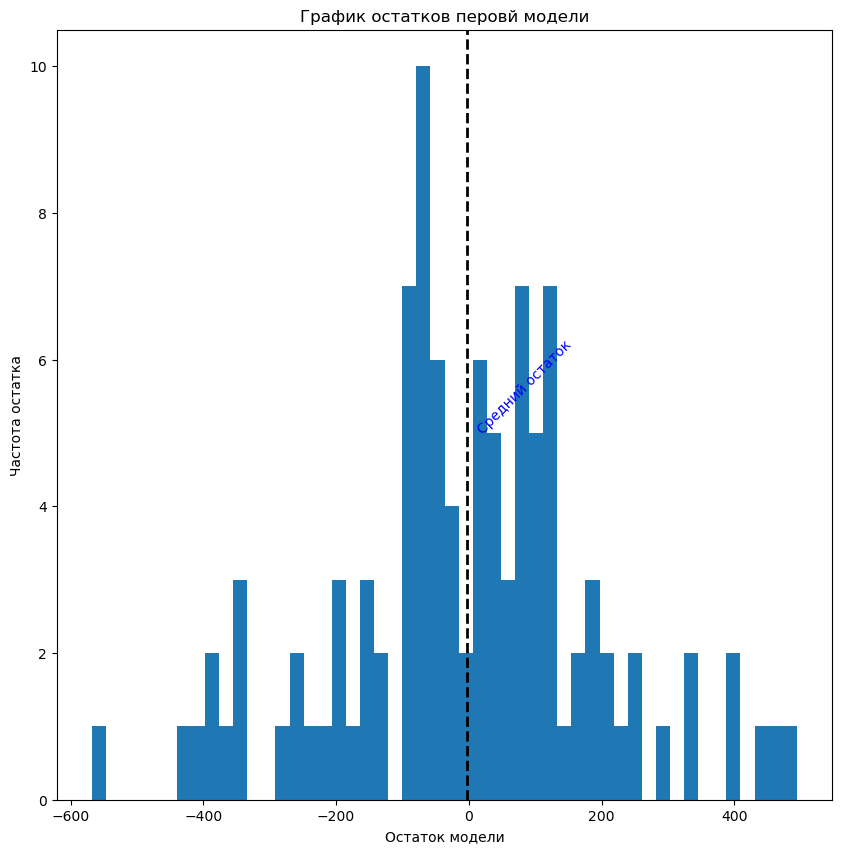

In [66]:
residuals_1 = y_pred_1 - y_test_1
fig, ax = plt.subplots(figsize=(10, 10))
ax.hist(residuals_1, bins=50)
ax.axvline(residuals_1.mean(), color='k', linestyle='dashed', linewidth=2, label="Средний остаток")
ax.text(10.2, 5 ,'Средний остаток',rotation=45, c="b")
ax.set_title("График остатков перовй модели")
ax.set(xlabel="Остаток модели", ylabel="Частота остатка")

Заметны Выбросы в негативную сторону. Следовательно, модель иногда переоценивает значения надоя.

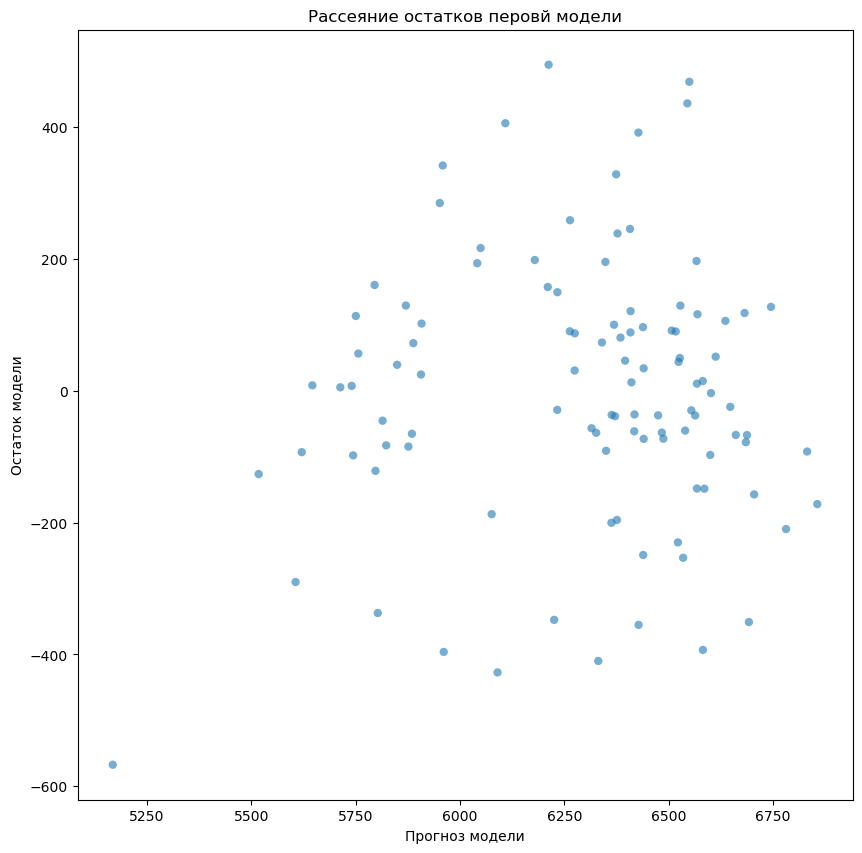

In [67]:
fig, ax = plt.subplots(figsize=(10, 10))
sct = ax.scatter(y_pred_1, residuals_1, alpha=0.6, edgecolors="none")
ax.set_title(f"Рассеяние остатков перовй модели")
ax.set(xlabel="Прогноз модели", ylabel="Остаток модели")
plt.show()

Видно два кластера остатков и два выброса. Причём до 6100 литров надля в год остатки линейно зависят от надоя и ошибка предсказания модели линейно увеличивается для надоя в интервале от 5400 до 6100 литров в год. При показателях больше 6100  литров зависимость обратная и тоже похода на линейную. Следуюет выделить новые признаки и оставить те из исходных, которые лучше всего отражают линеёную связь с надоем.

Видно два кластера остатков и два выброса. Причём до 6100 литров надля в год остатки линейно зависят от надоя и ошибка предсказания модели линейно увеличивается для надоя в интервале от 5400 до 6100 литров в год. При показателях больше 6100  литров зависимость обратная и тоже похода на линейную. Следуюет выделить новые признаки и оставить те из исходных, которые лучше всего отражают линеёную связь с надоем.

### Создание признаков

Создадим категориальные признаки для сахаро-протеинового соотношения корма и жирности молока.

In [68]:
SPR_lower_border = 0.87
SPR_upper_border = 0.92
own_herd["SPR_class"] = own_herd["SPR"].apply(lambda x: "low" \
    if x < SPR_lower_border else ("high" if x >= SPR_upper_border \
                else "mid"))

fatness_lower_border = 3.55
fatness_upper_border = 3.65
own_herd["fatness_class"] = own_herd["fatness"].apply(lambda x: "low" \
    if x < fatness_lower_border else ("high" if x >= fatness_upper_border \
                else "mid"))

Добавим так же синтетический признак: отношение жирности молока к питательности корма. 

In [69]:
own_herd["fat_protein_ratio"] = own_herd["fatness"] / own_herd["proteins"]

Проверим информатичность синтетического признака для предсказания надоя.

In [70]:
phi_k = own_herd.drop("id", axis = 1).phik_matrix(interval_cols = ["yield", "fat_protein_ratio"])
corr = phi_k["yield"]["fat_protein_ratio"]
print(f"Корреляция надоя с жиро-белковым соотношением: {corr * 100:.2f}%")

c:\Users\yka\AppData\Local\anaconda3\envs\practicum\lib\site-packages\phik\data_quality.py:82: UserWarning: Not enough unique value for variable is_old for analysis 1. Dropping this column
  warnings.warn(


Корреляция надоя с жиро-белковым соотношением: 63.17%


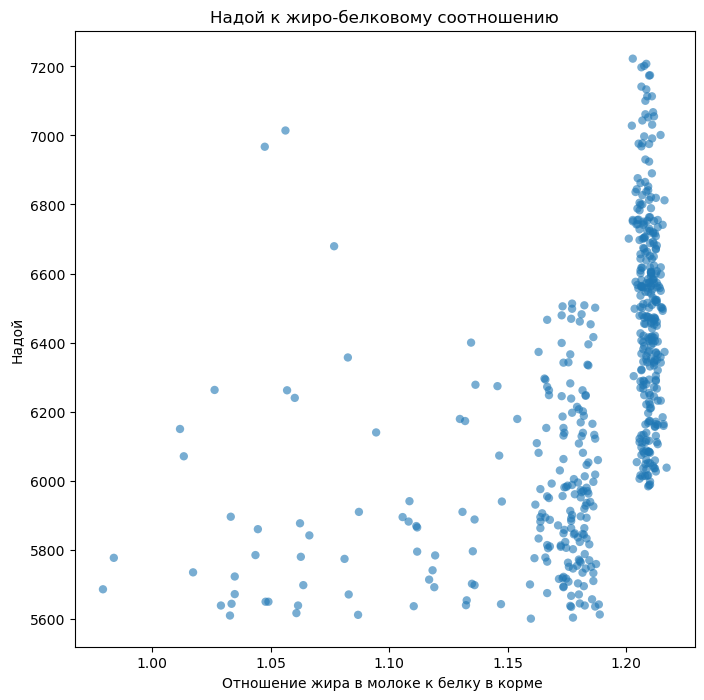

In [71]:
fig, ax = plt.subplots(figsize=(8, 8))
sct = ax.scatter(own_herd["fat_protein_ratio"], own_herd["yield"], alpha=0.6, edgecolors="none")
ax.set_title(f"Надой к жиро-белковому соотношению")
ax.set(xlabel="Отношение жира в молоке к белку в корме ", ylabel="Надой")
plt.show()

Сгенерированный признак оказался менее информативным, чем жирность молока т.к. корреляция этого признака с надоем ниже. 

Создадим новый признак "питательность в квадрате" (ЭКЕ в квадрате) и изучим, наскколько он информативен.

In [72]:
own_herd["EFU_squared"] = own_herd["EFU"] ** 2

phi_k = own_herd.drop("id", axis = 1).phik_matrix(interval_cols = ["yield", "EFU_squared"])
corr = phi_k["yield"]["EFU_squared"]
print(f"Корреляция надоя квадратом питательности корма: {corr * 100:.2f}%")

c:\Users\yka\AppData\Local\anaconda3\envs\practicum\lib\site-packages\phik\data_quality.py:82: UserWarning: Not enough unique value for variable is_old for analysis 1. Dropping this column
  warnings.warn(


Корреляция надоя квадратом питательности корма: 65.96%


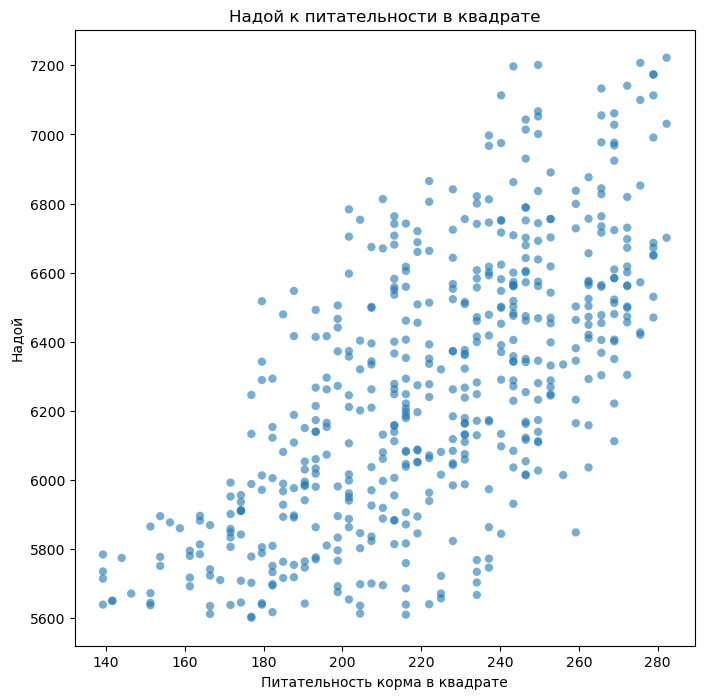

In [73]:
fig, ax = plt.subplots(figsize=(8, 8))
sct = ax.scatter(own_herd["EFU_squared"], own_herd["yield"], alpha=0.6, edgecolors="none")
ax.set_title(f"Надой к питательности в квадрате")
ax.set(xlabel="Питательность корма в квадрате", ylabel="Надой")
plt.show()

Характер зависимости явно не изменился. Корреляция с целевым признаком уменьшилась. На изначальном графике рассеяния питательности к надою видна почти линейная зависимость признаков. Делаем вывод, что подсказка из текста задания ложная.

### Вторая модель линейной регрессии

In [74]:
X = own_herd.drop([ "yield", "id", "is_milk_tasty", "is_old", "EFU", "SPR", "proteins", "fatness"], axis = 1)
X_train, X_test, y_train, y_test_2 = train_test_split(X, y, test_size=0.2)
X_train = pd.get_dummies(X_train, drop_first=True)
X_test = pd.get_dummies(X_test, drop_first=True)
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

model_2 = LinearRegression()
model_2.fit(X_train, y_train)

y_pred_2 = model_2.predict(X_test)

Проанализируем качество получившейся модели.

In [75]:
r2 = r2_score(y_test_2, y_pred_2)
print(f"Значение R2 второй модели: {r2}")

Значение R2 второй модели: 0.7673137401934551


[Text(0.5, 0, 'Остаток модели'), Text(0, 0.5, 'Частота остатка')]

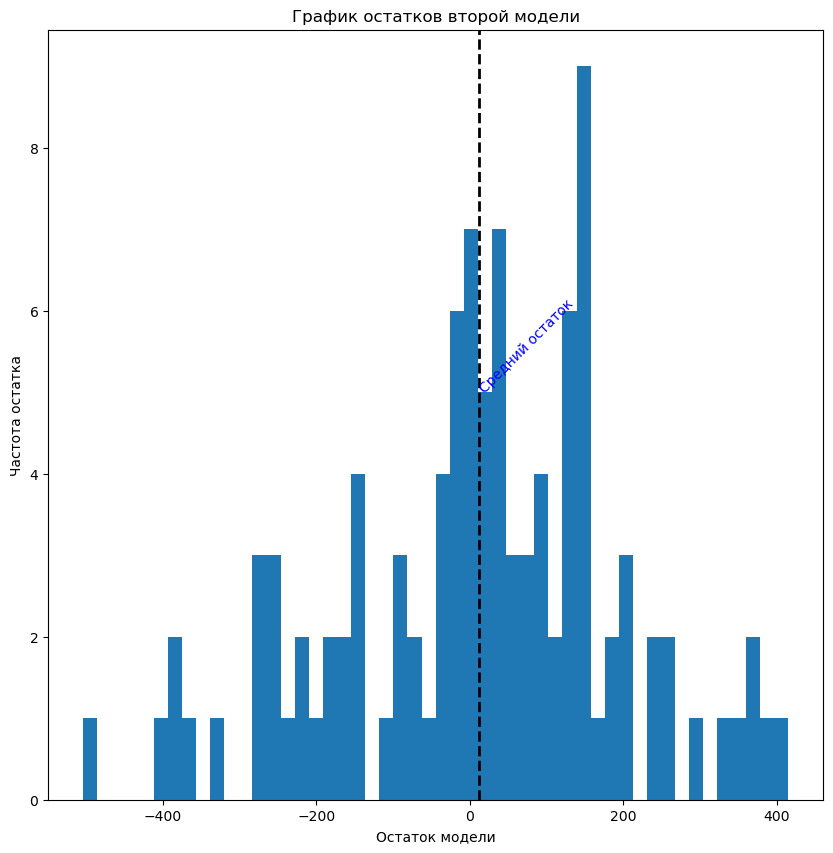

In [76]:
residuals_2 = y_pred_2 - y_test_2
fig, ax = plt.subplots(figsize=(10, 10))
ax.hist(residuals_2, bins=50)
ax.axvline(residuals_2.mean(), color='k', linestyle='dashed', linewidth=2, label="Средний остаток")
ax.text(10.2, 5 ,'Средний остаток',rotation=45, c="b")
ax.set_title("График остатков второй модели")
ax.set(xlabel="Остаток модели", ylabel="Частота остатка")

Распределение остатков стало симметричным и без явно заметных выбросов.

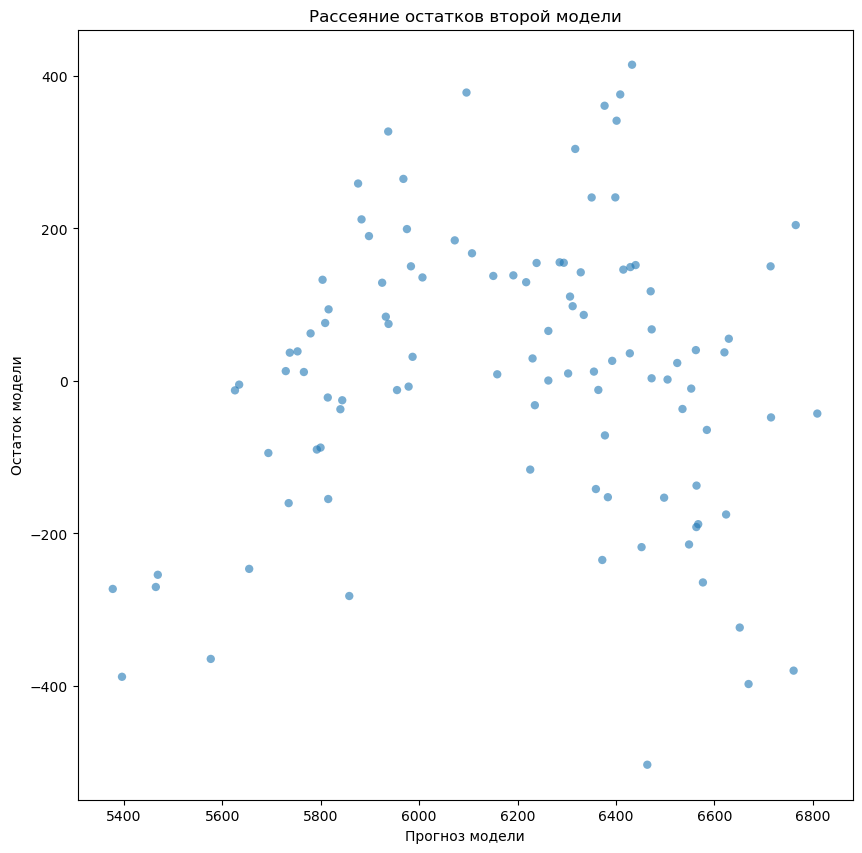

In [77]:
fig, ax = plt.subplots(figsize=(10, 10))
sct = ax.scatter(y_pred_2, residuals_2, alpha=0.6, edgecolors="none")
ax.set_title(f"Рассеяние остатков второй модели")
ax.set(xlabel="Прогноз модели", ylabel="Остаток модели")
plt.show()

Всё ещё идно два кластера остатков. При этом разброс остатков стал чуть ниже и симметричнее для всех прогнозных значений. Модель в целом стала чуть лучше и по относительной метрике R^2 и по анализу графиков разброса остатков.

### Третяя модель линейной регрессии

Объединим таблицы для добавления нового признака.

In [78]:
own_herd = pd.merge(own_herd, cows_ancestor, on="id")

Проанализируем связь нового признака с целевым.

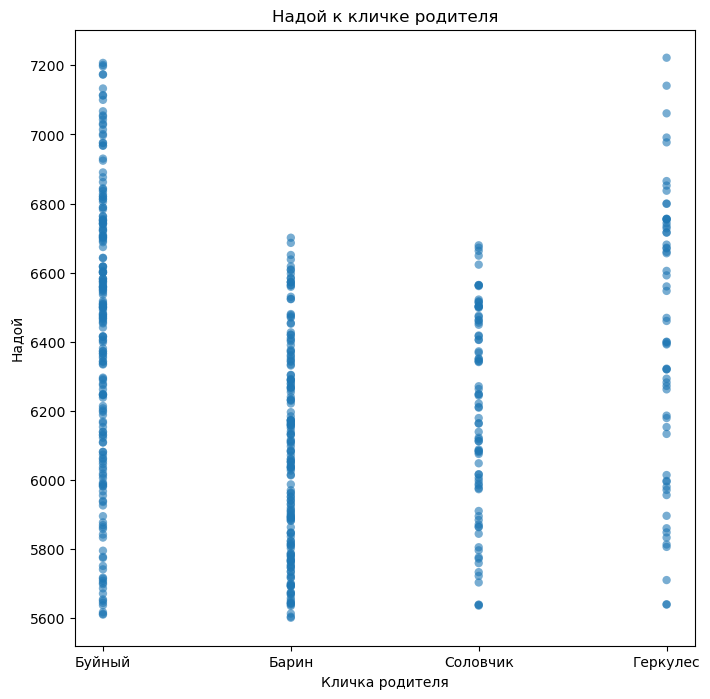

In [79]:
fig, ax = plt.subplots(figsize=(8, 8))
sct = ax.scatter(own_herd["ancestor_name"], own_herd["yield"], alpha=0.6, edgecolors="none")
ax.set_title(f"Надой к кличке родителя")
ax.set(xlabel="Кличка родителя", ylabel="Надой")
plt.show()

Подготовим данные и обучим третью модель.

In [80]:
X = own_herd.drop([ "yield", "id", "is_milk_tasty", "is_old", "EFU", "SPR", "proteins", "fatness"], axis = 1)
X_train_3, X_test, y_train_3, y_test_3 = train_test_split(X, y, test_size=0.2)
X_train_3 = pd.get_dummies(X_train_3, drop_first=True)
train_cols = X_train_3.columns
X_test = pd.get_dummies(X_test, drop_first=True)
scaler = StandardScaler()
scaler.fit(X_train_3)
X_train_3 = scaler.transform(X_train_3)
X_test = scaler.transform(X_test)

model_3 = LinearRegression()
model_3.fit(X_train_3, y_train_3)

y_pred_3 = model_3.predict(X_test)

Проанализируем качество получившейся модели.

In [81]:
r2 = r2_score(y_test_3, y_pred_3)
print(f"Значение R2 третей модели: {r2}")

Значение R2 третей модели: 0.7943156861680134


[Text(0.5, 0, 'Остаток модели'), Text(0, 0.5, 'Частота остатка')]

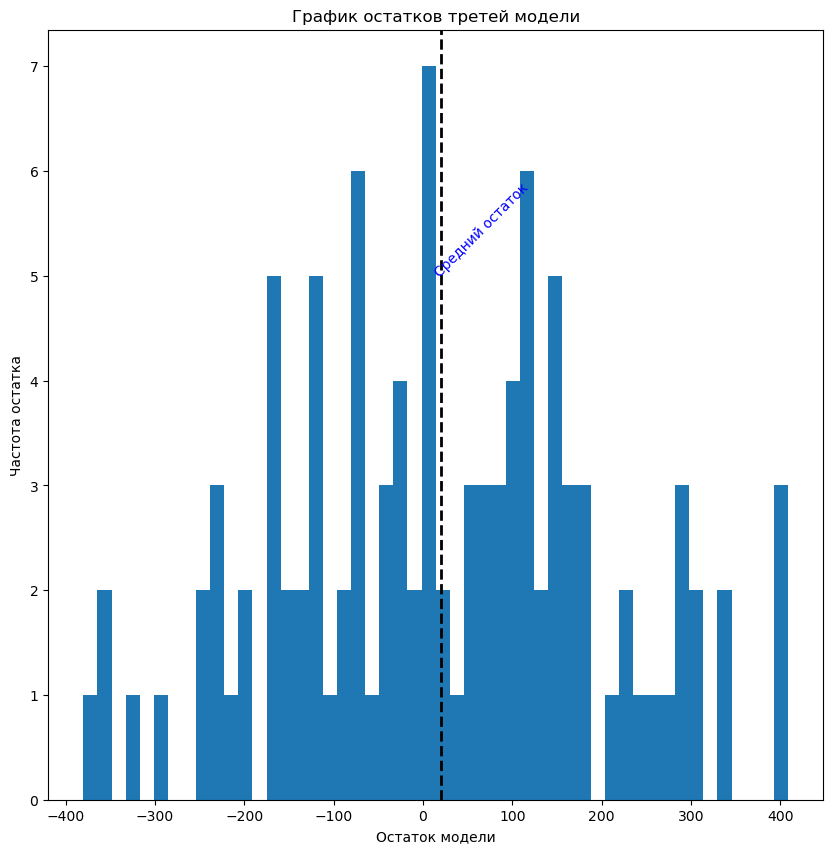

In [82]:
residuals_3 = y_pred_3 - y_test_3
fig, ax = plt.subplots(figsize=(10, 10))
ax.hist(residuals_3, bins=50)
ax.axvline(residuals_3.mean(), color='k', linestyle='dashed', linewidth=2, label="Средний остаток")
ax.text(10.2, 5 ,'Средний остаток',rotation=45, c="b")
ax.set_title("График остатков третей модели")
ax.set(xlabel="Остаток модели", ylabel="Частота остатка")

Среднее значение остатков не совпадает с модой, но находится очень близко к нулю. График получившейся частоты распределения напоминает нормальный, однако мода не равна среднему. Сильных выбросов нет.

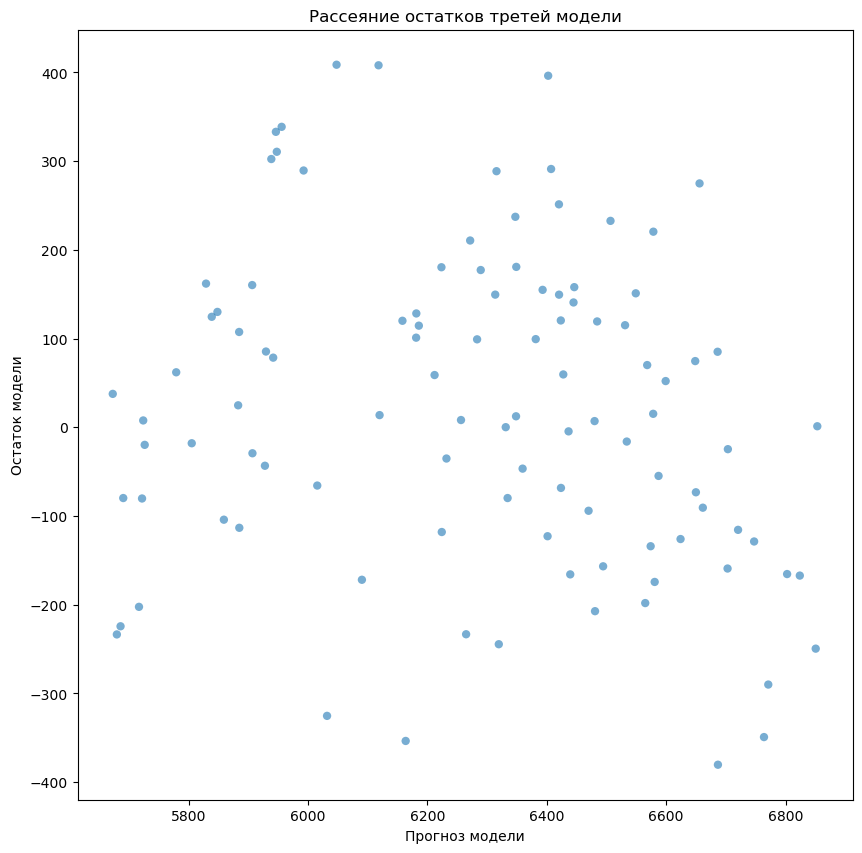

In [83]:
fig, ax = plt.subplots(figsize=(10, 10))
sct = ax.scatter(y_pred_3, residuals_3, alpha=0.6, edgecolors="none")
ax.set_title(f"Рассеяние остатков третей модели")
ax.set(xlabel="Прогноз модели", ylabel="Остаток модели")
plt.show()

Кластеры остатков незаметны. Разброс остатков стал чуть менее симметричным относительно нуля остатков. Выьросы не наблюдаются. По метрике R^2 третяя модель чуть хуже второй. В целом учитывая равномерность распределения ошибок относительно целевого признака вторая и третяя модели сопоставимы по качеству.

### Сравнение метрик моделей

In [84]:
mse = []
mrse = []
mae = []

for i in range(1, 4):
   mse.append(mean_squared_error(globals()[f"y_test_{i}"], globals()[f"y_pred_{i}"]))
   mrse.append(mean_squared_error(globals()[f"y_test_{i}"], globals()[f"y_pred_{i}"], squared=False))
   mae.append(mean_absolute_error(globals()[f"y_test_{i}"], globals()[f"y_pred_{i}"]))

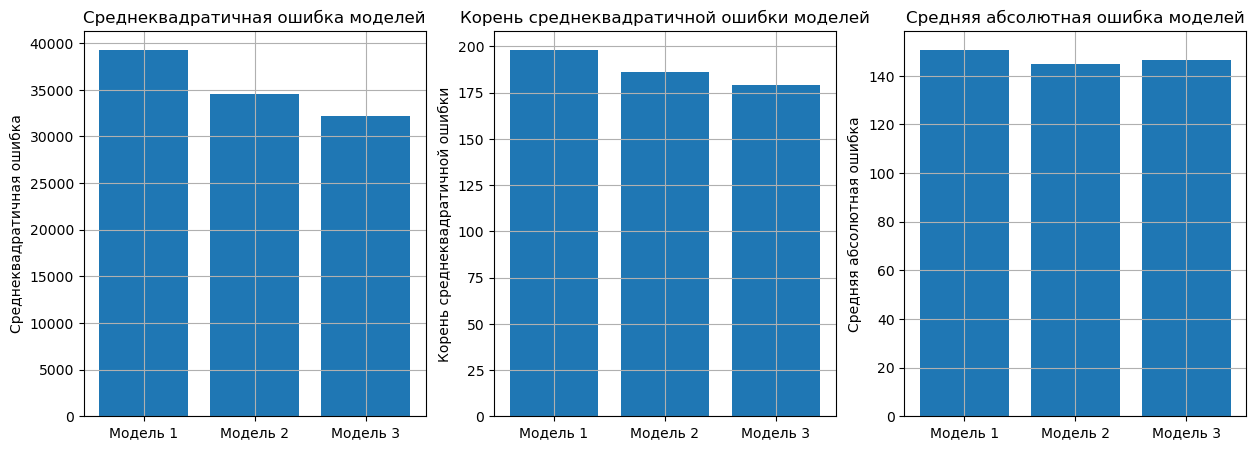

In [85]:
metric_names = ["Среднеквадратичная ошибка", "Корень среднеквадратичной ошибки", "Средняя абсолютная ошибка"]
models = ['Модель ' + str(i) for i in range(1, 4)]
values = [mse, mrse, mae]

fig, ax = plt.subplots(ncols=3, figsize=(15, 5))
for i in range(0, 3):
    ax[i].bar(models, values[i])
    ax[i].set_ylabel(metric_names[i])
    ax[i].set_title(f'{metric_names[i]} моделей')
    ax[i].grid(True)

plt.show()

Исходя из всех доступных метрик моделей, третяя модель наилучшая по качеству.

Посчитаем доверительный интервал прогноза модели.

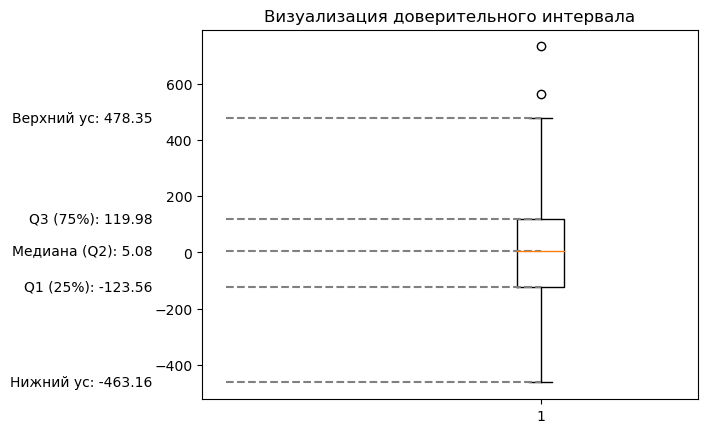

In [86]:
fig, ax = plt.subplots()
bp = ax.boxplot(model_3.predict(X_train_3) - y_train_3)
q1 = bp['boxes'][0].get_path().vertices[0, 1]
median = bp['medians'][0].get_ydata()[0]
q3 = bp['boxes'][0].get_path().vertices[2, 1]
lower_whisker = bp['caps'][0].get_ydata()[0]
upper_whisker = bp['caps'][1].get_ydata()[0]
iqr = q3 - q1
values = [lower_whisker, q1, median, q3, upper_whisker]
labels = [
    f'Нижний ус: {lower_whisker:.2f}',
    f'Q1 (25%): {q1:.2f}',
    f'Медиана (Q2): {median:.2f}',
    f'Q3 (75%): {q3:.2f}',
    f'Верхний ус: {upper_whisker:.2f}'
]

for y, label in zip(values, labels):
    ax.hlines(y, xmin=0, xmax=1, color='gray', linestyle='--')
    ax.text(-0.1, y, label, transform=ax.get_yaxis_transform(), ha='right', va='center')
ax.set_title('Визуализация доверительного интервала')
plt.show()

В предсказаниях модели с остатками в отрезке [-123, 121] можно быть уверенными.

### Прогноз надоя продаваемых коров

Добавим недостающие признаки в соответствии с условием задачи.

In [87]:
new_columns = own_herd[["EFU", "raw_protein", "SPR"]]

for col in new_columns:
    sale_herd[col] = new_columns[col].mean() * 1.05



Отфильтруем не взрослых коров.

In [88]:
sale_herd = sale_herd[sale_herd["is_old"]]

Сгенерируем новые признаки.

In [89]:
SPR_lower_border = 0.87
SPR_upper_border = 0.92
sale_herd["SPR_class"] = sale_herd["SPR"].apply(lambda x: "low" \
    if x < SPR_lower_border else ("high" if x >= SPR_upper_border \
                else "mid"))

fatness_lower_border = 3.55
fatness_upper_border = 3.65
sale_herd["fatness_class"] = sale_herd["fatness"].apply(lambda x: "low" \
    if x < fatness_lower_border else ("high" if x >= fatness_upper_border \
                else "mid"))
sale_herd["fat_protein_ratio"] = sale_herd["fatness"] / sale_herd["proteins"]
sale_herd["EFU_squared"] = sale_herd["EFU"] ** 2

Спрогнозируем надои коров лучшей моделью.

In [ ]:
sale_herd = sale_herd.astype({"raw_protein": "int64",
    "pasture_type": "object",
    "ancestor_breed": "object"
    })
X_new_encoded = pd.get_dummies(sale_herd, drop_first=True).reindex(columns=train_cols, fill_value=0)
X_new_scaled = StandardScaler().fit_transform(X_new_encoded)
y_pred_new = model_3.predict(X_new_scaled)

array([6129.31329439, 5892.67623916, 6256.06816722, 6179.56817843,
       6254.70782564, 6087.42961313, 6298.41442943, 5972.88686325,
       6255.76448829])

## Обучение модели логистической регрессии

In [ ]:
X = own_herd.drop([ 
    "id", "is_milk_tasty", "is_old", "breed", "ancestor_breed", "ancestor_name"
    ], axis = 1)
y = own_herd["is_milk_tasty"]
X_train_4, X_test, y_train_4, y_test_4 = train_test_split(X, y, test_size=0.2)
y_train_4 = y_train_4.astype(int)
y_test_4 = y_test_4.astype(int)
X_train_4 = pd.get_dummies(X_train_4, drop_first=True)
log_train_cols = X_train_4.columns
X_test = pd.get_dummies(X_test, drop_first=True)
scaler = StandardScaler()
scaler.fit(X_train_4)
X_train_4 = scaler.transform(X_train_4)
X_test = scaler.transform(X_test)

clf = LogisticRegression()
clf = clf.fit(X_train_4, y_train_4)
y_pred = clf.predict(X_test)
y_proba = clf.predict_proba(X_test)[:,1]

Оценим метрики модели классификации.

In [93]:
def print_metrics(y_test, y_pred):
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    print(f"Доля верных предсказаний: {accuracy:.3f}\nТочность: {precision:.3f}\nПолнота: {recall:.3f}")

print_metrics(y_test_4, y_pred)

Доля верных предсказаний: 0.673
Точность: 0.696
Полнота: 0.787


Далее расспотрим матрицу ошибок.

Text(0.5, 23.52222222222222, 'Предсказание')

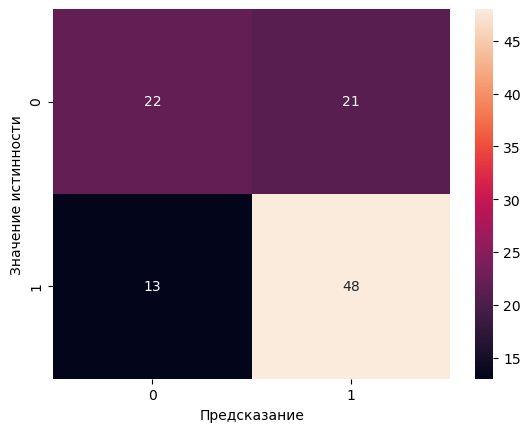

In [94]:
sns.heatmap(confusion_matrix(y_test_4, y_pred), annot=True)
plt.ylabel("Значение истинности")
plt.xlabel("Предсказание")

Т.к. цель найти коров со вкусным молоком, нужно минимизировать ложноположительные результаты предсказания, FP, поэтому будем минимизировать ошибку первого рода, которых 20.

Оптимальный порог для минимизации ошибки первого рода: 0.89


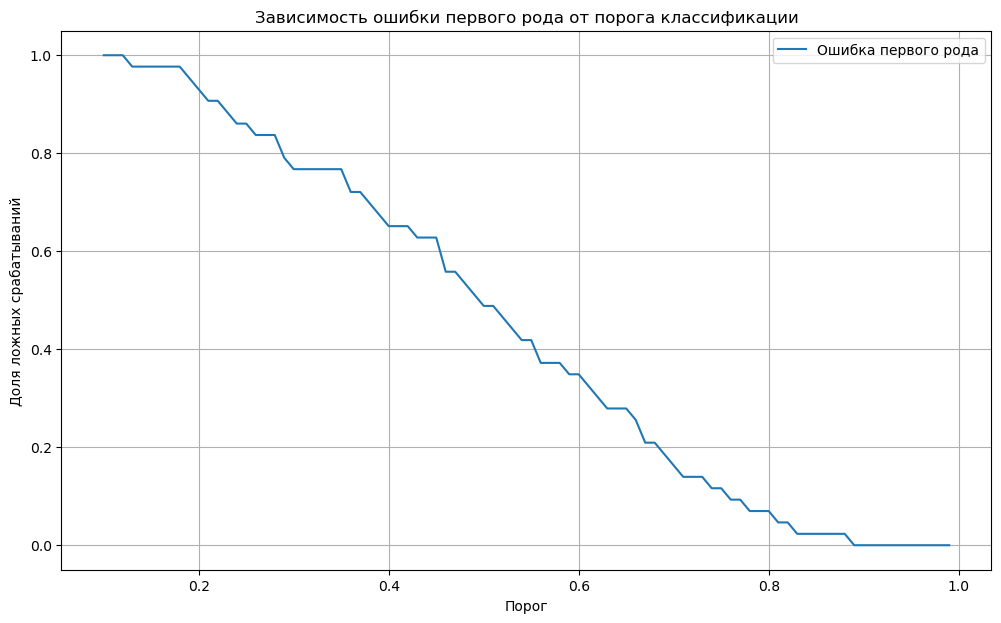

In [95]:
data = pd.DataFrame(zip(y_test_4, y_proba),
                    columns = ["y_valid", "y_proba"]).sort_values(by="y_proba",ascending=False)
columns = []
thresholds = [round(i, 2) for i in np.linspace(0.1, 1, num = 100, endpoint=False)]

for i in thresholds:
    columns.append("y_pred_"+str(i))
    data["y_pred_"+str(i)] = data["y_proba"].apply(lambda x: 1 if x > i else 0)

total_negatives = (data["y_valid"] == 0).sum()
type_1_errors = []

for thresh in thresholds:
    predicted_positives = data["y_proba"] > thresh
    false_positives = ((predicted_positives == True) & (data["y_valid"] == 0)).sum()
    fp_rate = false_positives / total_negatives if total_negatives > 0 else 0
    type_1_errors.append(fp_rate)

optimal_threshold_index = np.argmin(type_1_errors)
optimal_threshold = thresholds[optimal_threshold_index]
print(f"Оптимальный порог для минимизации ошибки первого рода: {optimal_threshold:.2f}")

plt.figure(figsize=(12, 7))
plt.plot(thresholds, type_1_errors, linestyle='-', label="Ошибка первого рода")
plt.title("Зависимость ошибки первого рода от порога классификации")
plt.xlabel("Порог")
plt.ylabel("Доля ложных срабатываний")
plt.legend()
plt.grid(True)
plt.savefig('type_1_error_plot.png')

Построим прогноз с оптимальным порогом и оценим метрики.

In [101]:
def custom_predict(X, threshold):
    probs = clf.predict_proba(X) 
    return (probs[:, 1] > threshold).astype(int)

adjusted_predicts = custom_predict(X_test, threshold=0.89)
print_metrics(y_test_4, adjusted_predicts)

Доля верных предсказаний: 0.490
Точность: 1.000
Полнота: 0.131


Text(0.5, 23.52222222222222, 'Предсказание')

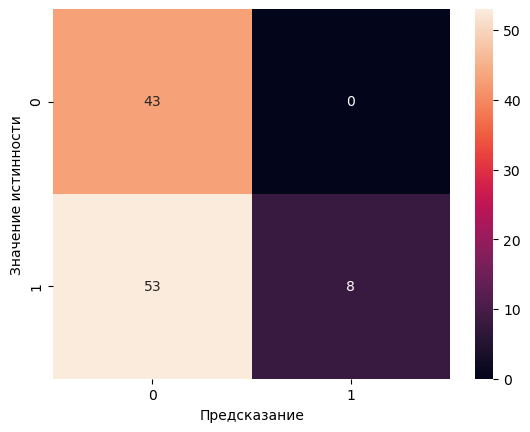

In [99]:
sns.heatmap(confusion_matrix(y_test_4, adjusted_predicts), annot=True)
plt.ylabel("Значение истинности")
plt.xlabel("Предсказание")

Общая точность предсказания модели значительно упала, но теперь модель не допускает ошибки, при которых она ложно выбирает коров с невкусным молоком. Это соответствует запросу бизнеса. Спрогнозируем, какие из коров из стада на продажу дадут вкусное молоко.

## Итоговые выводы